In [1]:
### A Pluto.jl notebook ###
# v0.17.3

using Markdown
using InteractiveUtils

# This Pluto notebook uses @bind for interactivity. When running this notebook outside of Pluto, the following 'mock version' of @bind gives bound variables a default value (instead of an error).
macro bind(def, element)
    quote
        local iv = try Base.loaded_modules[Base.PkgId(Base.UUID("6e696c72-6542-2067-7265-42206c756150"), "AbstractPlutoDingetjes")].Bonds.initial_value catch; b -> missing; end
        local el = $(esc(element))
        global $(esc(def)) = Core.applicable(Base.get, el) ? Base.get(el) : iv(el)
        el
    end
end

@bind (macro with 1 method)

In [2]:
begin
	
	begin
	    #using Revise
		import ScikitLearn
		import PlutoUI
	    import LOLTools
	    import JSON3
	    import CSV
	  	import HTTP
	  	import LOLTools
		using Random
	    using Base.Threads
	    using DataFrames
	    using DataFramesMeta
	    using Chain
	    using SharedArrays
	    using FileIO
		using Distributed
	end;
	
	#import data and processing packages
	import LOLTools
	import JSON3
	import CSV
	import DataFrames
	import DataFramesMeta
	import HTTP
	
	
	"""
	Given a type of event and a dataframe of events
	Returns a dataframe filtered by the given type
	"""
	function displayEvents(df::DataFrames.DataFrame,eventType::AbstractString)::DataFrames.DataFrame
	    tmp = filter(:type => x -> x==eventType ,df;view=false)
	    tmp = tmp[!, all.(! ismissing,eachcol(tmp))]
	    #vscodedisplay(tmp)
	    return tmp
	end
	
	export recKeysPrint,getMatchIds,getEvents,displayEvents,getMetadata,getPlayersData,getPlayersDataAndEvents
	export eventsListDfs
	
	function getMetadata(pmd::LOLTools.MatchV5.MatchDto)
	    filt = Tuple(
	    x for x in fieldnames(typeof(pmd.info))
	    if !(x in (:participants,:teams))
	    )
	    return NamedTuple{filt}(pmd.info)
	end
	
	"""
	Returns a list of all events of a match given its timelinedata
	"""
	function getEvents(tmd::LOLTools.MatchV5.MatchTimelineDto)::Base.MethodList
	    #iterate over frames
	    events_list = Array{Any}(undef)
	    for frame in tmd.info.frames
	        #get events
	        push!(events_list,frame.events...)
	    end
	    return (
	        frameInterval = tmd.info.frameInterval,
	        eventsList = events_list
	    )
	end
	
	function getPlayersData(pmd::LOLTools.MatchV5.MatchDto,tmd::LOLTools.MatchV5.MatchTimelineDto)
	    players = Dict()
	    for i in 1:10
	        participant_frames = []
	        for frame in tmd.info.frames
	            push!(
	                participant_frames,
	                frame.participantFrames[i]
	            );
	        end
	        push!(
	            players,
	            Symbol(pmd.info.participants[i].summonerName) => (
	                timeline = participant_frames,
	                postmatch = pmd.info.participants[i]
	            )
	        );
	    end
	    nt = (;players...);
	    return nt
	end
	
	function getPlayersDataAndEvents(pmd::LOLTools.MatchV5.MatchDto,tmd::LOLTools.MatchV5.MatchTimelineDto)
	    events_list = []
	    players = Dict()
	    for i in 1:10
	        participant_frames = []
	        for frame in tmd.info.frames
	            push!(
	                participant_frames,
	                frame.participantFrames[i]
	            );
	            if i == 1
	                push!(events_list,frame.events...)
	            end
	        end
	        push!(
	            players,
	            Symbol(pmd.info.participants[i].summonerName) => (
	                timeline = participant_frames,
	                postmatch = pmd.info.participants[i]
	            )
	        );
	    end
	    nt = (;players...);
	    eventsout = (
	        frameInterval = tmd.info.frameInterval,
	        eventsList = events_list
	    )
	    return nt,eventsout
	end
	
	function recKeysPrint(x;keysSet=Set(),level=0,symmetric = true, echo = true ,f= (k,v)->k, visitAll = false)
	    if isa(x,NamedTuple)
	        for key in keys(x)
	            if !(key in keysSet) | visitAll == true
	                if echo == true
	                    println("   "^level * f(String(key),x[key]))
	                else
	                    if ! isa(x[key],NamedTuple)
	                        f(String(key),x[key]);
	                    end
	                end
	                push!(keysSet,key);
	            end
	            recKeysPrint(x[Symbol(key)],keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo, visitAll = visitAll)
	        end
	    end
	    if isa(x,Vector) | isa(x,Tuple)
	        if symmetric == true
	            if echo == true
	                println("   "^(level+1) * "[Array of $(size(x)[1]) elements]")
	            end
	            recKeysPrint(x[1],keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo, visitAll = visitAll)
	        else
	            for el in x
	                recKeysPrint(el,keysSet = keysSet,level = level+1,symmetric = symmetric, f= f,echo = echo)
	            end
	        end
	    end
	end
	
	"""
	    queue
	    type
	    etc
	"""
	function getMatchIds(puuid :: String,api_key=api_key::String,region=region::String;start::Int=0,count::Int=20, kwargs...)
	    header=Dict(
	        "User-Agent" => "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36",
	        "Accept-Language" => "it-IT,it;q=0.9,en-US;q=0.8,en;q=0.7",
	        "Accept-Charset" => "application/x-www-form-urlencoded; charset=UTF-8",
	        "Origin" => "https://developer.riotgames.com",
	        "X-Riot-Token" => "$(api_key)");
	    args = []
	    for arg in kwargs
	        k,v = arg
	        if k != nothing
	            push!(args,"&$k=$v")
	        end
	    end
	    rep = HTTP.get("https://$(region).api.riotgames.com/lol/match/v5/matches/by-puuid/$(puuid)/ids?start=$(start)&count=$(count)"*"$(args...)",headers=header);
	    return collect(m.match for m in eachmatch(Regex(raw"(\w+_\w+)"),String(rep.body)))
	end
	
	function eventsListToDf(eventslist::Vector{Any})::DataFrames.DataFrame
	    #calculate columns
	    eventkeys = Set()
	    for event in eventslist
	        push!(eventkeys,keys(event)...)
	    end
	    nt = (; zip(eventkeys, Any[] for i in 1:length(eventkeys))...)
	
	    #init
	    eventsdf = DataFrame(nt)
	    #push events
	    for ev in eventslist
	        push!(eventsdf,ev;cols=:subset)
	    end
	    return eventsdf
	end
end

eventsListToDf (generic function with 1 method)

In [3]:
begin
    using Query
    import Statistics
    using VegaLite
end

In [4]:
begin
	using Images
	
	img = load("./assets/icons/-1.png")
	function handwrittenresize(img)
	    tmp = Array{Images.RGBA{Images.N0f8}}(undef,0)
	    if size(img) == (360,360)
	      for r in 1:size(img)[1]
	          for c in 1:size(img)[2]
	              if r%3==0 && c%3==0
	                  push!(tmp,img[c,r])
	              end
	          end
	      end
	    else
	      return img
	    end
	
	    return reshape(tmp,(120,120))
	end
	resized = handwrittenresize(img)
	FileIO.save("./assets/icons/-1.png",resized);
end;

In [5]:
begin
	using ImageDraw
	xy2coord(x,y) = Dict(:x=>floor(Int,x/14870*512),:y=>floor(Int,y/14870*512))
end;

In [6]:
# # Installation cell
# %%capture
# %%shell
# if ! command -v julia 3>&1 > /dev/null
# then
#     wget -q 'https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.0-linux-x86_64.tar.gz' \
#         -O /tmp/julia.tar.gz
#     tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
#     rm /tmp/julia.tar.gz
# fi
# julia -e 'using Pkg; pkg"add IJulia; precompile;"'
# echo 'Done'

In [7]:
# !curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.0-linux-x86_64.tar.gz" -o julia.tar.gz
# !tar -xzf julia.tar.gz -C /usr --strip-components 1
# !rm -rf julia.tar.gz*
# !julia -e 'using Pkg; Pkg.add("IJulia"); precompile'

In [8]:
html"""<style>
main {
    max-width: 1000px;
}
"""

HTML{String}("<style>\nmain {\n    max-width: 1000px;\n}\n")

In [9]:
hostTeam = "TEST"

"Pertico"

In [10]:
teamName = "team08122021"

"team08122021"

In [11]:
path = "./teams/$hostTeam/$teamName/"

"./teams/Pertico/team08122021/"

In [12]:
#=
begin
	 import Pkg
	 Pkg.add(["HTTP"])
	 Pkg.add("LOLTools")
	 Pkg.add("JSON3")
	 Pkg.add("CSV")
	 Pkg.add("DataFrames")
	 Pkg.add("DataFramesMeta")
	 Pkg.add("Chain")
	 Pkg.add("SharedArrays")
	 Pkg.add("FileIO")
	 Pkg.add("PlutoUI")
end
=#

In [13]:
# Pkg.add(["Query","Statistics","VegaLite"])

In [14]:
begin
    matchId_debug = "EUW1_5572542603"
    region_debug = "EUROPE"
    token_key_debug = "RGAPI-13860ec2-c979-4d40-ac0a-71761533cb44"

    api_key_debug = LOLTools.get(ENV,"RIOT_TOKEN",token_key_debug)
end;

In [15]:
begin
    #define summoner names
    summonerNames = Vector{String}(undef,0)
    summonerNames = split(
            "Asrethet,Belu,OverextendingMid, Enneman, Faust1"
        ,",") |> 
    x->map(strip,x) |>
    x->map(strip,x) |>
    x->map(String,x)
    println("Giocatori \n" * join(summonerNames,"\n"))
    #find puuids
    println("Querying puuids...")
    puuids = Array{String}(undef,0)
    for name in summonerNames
        push!(puuids,LOLTools.SummonerV4.summoner_by_name(api_key_debug,"euw1",name).puuid)
        #sleep(0.05)
    end
    #useful dictionary
    id2name = Dict(zip(puuids,summonerNames))

    #get matchIds for every player
    println("Getting the match ids...")
    matchIds = Set{String}()
    for pid in puuids
        mids_pp = getMatchIds(
            pid,
            api_key_debug,
            region_debug,
            count=50,
            queue = 440, #flex
            startTime = 1636930800
        )
        global matchIds = union!(matchIds,mids_pp)
        sleep(0.1)
    end
    matchIds = map(string,collect(matchIds))
    
    #print somestuff
    #@show first(sort(matchIds),3)
    #@show last(sort(matchIds),3);
    l=length(matchIds)
	println("Numero di partite scaricate: $l")
    id2name
end;

Giocatori 
kagyu
not rava
teus3d
coach ego
innovigo
Querying puuids...
Getting the match ids...
Numero di partite scaricate: 3


In [16]:
function getMatchDatasSplit(matchIds,range,instance;api_key_debug=api_key_debug,region_debug=region_debug,sleepTime=0.3)
	local matchDatas1 = Array{NamedTuple}(undef,0)
	if ispath(path*"saved.txt")
		saved = split(read(path*"saved.txt",String))
	end
	for (k,mid) in collect(enumerate(matchIds[range[1]:range[2]]))
		mid = String(mid)
		if ispath(path*"saved.txt") && (mid in saved)
			#println("Instance $instance : Skipping $mid")
			continue
		end
		sleep(rand(collect(1.5:0.05:2.5))*sleepTime*2)
		postmatchData = LOLTools.MatchV5.match_by_match_id(
			api_key_debug,region_debug,mid
		);
		timelineData = LOLTools.MatchV5.match_timeline_by_match_id(
			api_key_debug,region_debug,mid
		);
		#get timelines and events
		players,events = getPlayersDataAndEvents(postmatchData,timelineData)
		#get myTeamId
		myTeamId = @from p in DataFrame(players) begin
			@where p.postmatch.puuid in puuids
			@select {p.postmatch.teamId}
			@collect DataFrame
		end
		myTeamId = @chain myTeamId begin
			groupby([:teamId])
			combine(nrow)
		end
		myTeamId = myTeamId[argmax(myTeamId.nrow...),:teamId]
		#struct the data
		matchInfo = (
			puuids = Dict(
				zip(
				postmatchData.metadata.participants,
				[postmatchData.info.participants[i].summonerName for i in 1:10]
				)
			),
			metadata = getMetadata(postmatchData),
			teams = postmatchData.info.teams,
			#players = getPlayersData(postmatchData,timelineData),
			#events = getEvents(timelineData)
			players = players,
			eventsContainer = events,
			myTeamId = myTeamId,
			matchId = mid
		);
		#push matchInfo
		push!(matchDatas1,matchInfo)
		#println("Instance $instance : Added $mid")
	end
	return matchDatas1
end;

In [17]:
nparall=length(workers());

In [18]:
data_splits = begin
	local interval = collect(0:div(l,nparall):l)
	local out = []
	for i in 1:(length(interval)-1)
		if i == (length(interval)-1)
			push!(out,(interval[i]+1,interval[i+1]+l%nparall))
		else
			push!(out,(interval[i]+1,interval[i+1]))
		end
	end
	out
end;

In [19]:
matchDatas = begin
	matchDatas_ = Array{Vector{NamedTuple}}(undef,length(data_splits))
	@sync for (i,range) in enumerate(data_splits)
		println("Assigning worker $i")
		sleep(5/length(data_splits))
		@async matchDatas_[i] = getMatchDatasSplit(matchIds,range,i,sleepTime=2.5*60/200*length(data_splits))
	end
	matchDatas = vcat(matchDatas_...)
end;

Assigning worker 1


In [20]:
#=
matchDatas = @sync begin
	matchDatas1 = @async begin
		local matchDatas1 = Array{NamedTuple}(undef,floor(Int,l/2))
		for (k,mid) in collect(enumerate(matchIds[1:floor(Int,l/2)]))
			mid = String(mid)
			postmatchData = LOLTools.MatchV5.match_by_match_id(
				api_key_debug,region_debug,mid
			);
	        timelineData = LOLTools.MatchV5.match_timeline_by_match_id(
				api_key_debug,region_debug,mid
			);
	        #get timelines and events
	        players,events = getPlayersDataAndEvents(postmatchData,timelineData)
	        #get myTeamId
	        myTeamId = @from p in DataFrame(players) begin
	            @where p.postmatch.puuid in puuids
	            @select {p.postmatch.teamId}
	            @collect DataFrame
	        end
	        myTeamId = @chain myTeamId begin
	            groupby([:teamId])
	            combine(nrow)
	        end
	        myTeamId = myTeamId[argmax(myTeamId.nrow...),:teamId]
	        #struct the data
	        matchInfo = (
	            puuids = Dict(
	                zip(
	                postmatchData.metadata.participants,
	                [postmatchData.info.participants[i].summonerName for i in 1:10]
	                )
	            ),
	            metadata = getMetadata(postmatchData),
	            teams = postmatchData.info.teams,
	            #players = getPlayersData(postmatchData,timelineData),
	            #events = getEvents(timelineData)
	            players = players,
	            eventsContainer = events,
	            myTeamId = myTeamId,
	            matchId = mid
	        );
	        #push matchInfo
	        matchDatas1[k]=matchInfo
			println("Added $mid")
		end
		matchDatas1
	end;
	
	matchDatas2 = @async begin
		local matchDatas2 = Array{NamedTuple}(undef,l-floor(Int,l/2))
		for (k,mid) in collect(enumerate(matchIds[(floor(Int,l/2)+1):end]))
			mid = String(mid)
			postmatchData = LOLTools.MatchV5.match_by_match_id(
				api_key_debug,region_debug,mid
			);
	        timelineData = LOLTools.MatchV5.match_timeline_by_match_id(
				api_key_debug,region_debug,mid
			);
	        #get timelines and events
	        players,events = getPlayersDataAndEvents(postmatchData,timelineData)
	        #get myTeamId
	        myTeamId = @from p in DataFrame(players) begin
	            @where p.postmatch.puuid in puuids
	            @select {p.postmatch.teamId}
	            @collect DataFrame
	        end
	        myTeamId = @chain myTeamId begin
	            groupby([:teamId])
	            combine(nrow)
	        end
	        myTeamId = myTeamId[argmax(myTeamId.nrow...),:teamId]
	        #struct the data
	        matchInfo = (
	            puuids = Dict(
	                zip(
	                postmatchData.metadata.participants,
	                [postmatchData.info.participants[i].summonerName for i in 1:10]
	                )
	            ),
	            metadata = getMetadata(postmatchData),
	            teams = postmatchData.info.teams,
	            #players = getPlayersData(postmatchData,timelineData),
	            #events = getEvents(timelineData)
	            players = players,
	            eventsContainer = events,
	            myTeamId = myTeamId,
	            matchId = mid
	        );
	        #push matchInfo
	        matchDatas2[k]=matchInfo
			println("Added $mid")
		end
		matchDatas2
	end;
	matchDatas = vcat(matchDatas1...,matchDatas2...)
end
=#

In [21]:
t_megaObjDf = Threads.@spawn begin
    megaObjDf = begin
        println("Creating a dataframe about objectives...")
        megaObjDf = DataFrame()
        for c in matchDatas
            out = DataFrame()
            for t in c.teams
                a = DataFrame(t.objectives)
                b = DataFrame(objName = collect(keys(t.objectives)),
                    teamId = t.teamId,
                    win = t.win,
                    myTeam = c.myTeamId,
                    matchId = c.matchId
                    )
                append!(out,[a b])
            end
            append!(megaObjDf,out)
        end
        megaObjDf
    end;
end;

Creating a dataframe about objectives...


In [22]:
t_megaBansDf = Threads.@spawn begin
    megaBansDf = begin
        println("Creating a dataframe of bans...")
        megaBansDf = DataFrame()
        for c in matchDatas
            out = DataFrame()
            for t in c.teams
                a = DataFrame(t.bans)
                b = DataFrame(
                    teamId = fill(t.teamId,length(t.bans)),
                    win = t.win,
                    myTeamId = c.myTeamId,
                    matchId = c.matchId
                    )
                append!(out,[a b])
            end
            append!(megaBansDf,out)
        end
        megaBansDf
    end;
end;

Creating a dataframe of bans...


In [23]:
# Pkg.add("Downloads")

In [24]:
mkpath("./assets/");

In [25]:
# download("http://ddragon.leagueoflegends.com/cdn/11.23.1/data/en_US/runesReforged.json", "./assets/runesReforged.json")

In [26]:
t_perksDataBase = Threads.@spawn begin

    println("Downloading a database of perks")

    perksDataBase = @chain "./assets/runesReforged.json" begin
        read(String)
        JSON3.read()
        DataFrame()
        @aside x = _
        flatten(:slots)
        map( x-> DataFrame(x.runes) , _[!,:slots])
        reduce(vcat,_)
        vcat(_,x[:,1:4];cols=:union)
    end;
end;

In [27]:
t_megaPostmatchDf = Threads.@spawn begin
    megaPostmatchDf = begin
        println("Creating a dataframe of postmatch data...")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #indice i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                a = push!(DataFrame(),p.postmatch)
    
                b = DataFrame(
                    matchId = m.matchId,
                    myTeamId = m.myTeamId,
                    gameDuration = m.metadata.gameDuration
                )
    
                append!(dfoo,[a b];cols=:union)
    
            end
            append!(dfooo,dfoo)
        end
        if length(matchDatas)>0
            select!(dfooo,Not(:perks))
        end
        dfooo
    end;
end;

Creating a dataframe of postmatch data...


In [28]:
t_megaTimelineDf = Threads.@spawn begin
    megaTimelineDf = begin
        println("Creating a dataframe of timeline player stats")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #index i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                dfo = DataFrame()
                #loop over frames
                for (k,frame) in enumerate(p.timeline) #array
                    
                    #we want to extract championStats,damageStats and position
                    local df = DataFrame()
                    #championStats
                    a = push!(DataFrame(),frame.championStats)
                    b = push!(DataFrame(),frame.damageStats)
                    c = push!(DataFrame(),frame.position)
    
                    KEYS = filter( x -> !(x in [:championStats,:damageStats,:position]) ,keys(frame))
                    
                    d = push!(DataFrame(),
                        NamedTuple{KEYS}(frame)
                    )
                    e = DataFrame(
                        timestamp = m.eventsContainer.frameInterval*(k-1),
                        frameInterval = m.eventsContainer.frameInterval,
                        myTeamId = m.myTeamId,
                        matchId = m.matchId,
                        puuid = collect(keys(m.puuids))[i]
                    )
                    df = [a b c d e]
                    append!(dfo, df) # primary secondary
                end
                append!(dfoo,dfo)
            end
            append!(dfooo,dfoo)
        end
        dfooo
    end;
end;

Creating a dataframe of timeline player stats


In [29]:
t_megaEventsDf = Threads.@spawn begin 
    megaEventsDf = begin
        println("Creating a dataframe of events")
        function f(x)
            y = eventsListToDf(x.eventsContainer.eventsList)
            l = size(y)[1]
            return DataFrame(matchId = fill(x.matchId,l),myTeamId = x.myTeamId)
        end
        tmp = map( x -> [eventsListToDf(x.eventsContainer.eventsList) f(x)], matchDatas)
        if length(tmp) > 0
            vcat(tmp...,cols=:union)
        else
            return DataFrame()
        end
    end;
end;

Creating a dataframe of events


In [30]:
perksDataBase = fetch(t_perksDataBase);

In [31]:
t_megaPerksDf = Threads.@spawn begin
    #perks
    megaPerksDf = begin
        println("Creating a dataframe of perks...")
        dfooo = DataFrame()
        for m in matchDatas
            name2puuid = Dict(map(reverse,collect(m.puuids))) # fram name to puuid
            playerSymbols = keys(m.players) # player symbols
            playerNames = map(string,playerSymbols) # player names(String)
            dfoo = DataFrame()
            for (i,p) in enumerate(m.players) #indice i player p
                #timeline ; postmatch
    
                #hint recKeysPrint(p.postmatch) or keys(p.postmatch)
                dfo = DataFrame()
                #stackPerks is not informative
                for style in p.postmatch.perks.styles #array of 2 elements
                    #description can be dropped
                    #we want selection and style, style is important
                    local df = DataFrame()
                    for s in style.selections #array of tuples
                        @chain DataFrame() begin
                            push!(s) #dataframe of what I want(selection)
                            hcat(# add additional information
                                DataFrame(
                                style=style.style,
                                puuid = name2puuid[playerNames[i]], 
                                matchId = m.matchId
                                )
                            )
                            
                            append!(df,_) #save
                        end
                        # tmp = push!(DataFrame(),s)
                        # tmp = hcat(tmp, DataFrame(style=style.style, puuid = name2puuid[playerNames[i]], matchId = m.matchId))
                        # append!(df,tmp)
                    end
                    append!(dfo, df) # primary secondary
                end
                append!(dfoo,dfo)
            end
            append!(dfooo,dfoo)
        end
        dfooo
    end;
end;

Creating a dataframe of perks...


In [32]:
begin
	megaEventsDf = fetch(t_megaEventsDf);
    if size(megaEventsDf)[1] != 0
        eventTypes = unique(megaEventsDf,"type")[!,:type]
    end
end;

In [33]:
# download("https://raw.communitydragon.org/json/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-icons/", "./iconsList.json")

In [34]:
# iconsList = JSON3.read(read("./iconsList.json"))
# mkpath("./assets/icons/")
# for item in iconsList
#   download("https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/champion-icons/$(item.name)","./assets/icons/$(item.name)")
# end

In [35]:
begin
	megaPerksDf_ = fetch(t_megaPerksDf)
	
	begin
        if size(megaPerksDf_)[1] != 0
            fromPerkIdToPerkName(database,id) = filter( (x-> x.id==(id)), database)[1,:key] 
            fromPerkIdToPerkIcon(database,id) = filter( (x-> x.id==(id)), database)[1,:icon]
            megaPerksDf = deepcopy(megaPerksDf_)
            megaPerksDf[!,:icon] = map(
                x-> "http://ddragon.leagueoflegends.com/cdn/img/" * fromPerkIdToPerkIcon(perksDataBase,x),
                megaPerksDf[:,:perk]
            ) 
            megaPerksDf[!,:perk] = map(x->fromPerkIdToPerkName(perksDataBase,x),megaPerksDf[:,:perk]) 
            megaPerksDf[!,:style] = map(x->fromPerkIdToPerkName(perksDataBase,x),megaPerksDf[:,:style]) 
        end
	end;
end;

In [36]:
macro name(x)
        string(x)
end;

In [37]:
if ! isdir(path)
        mkpath(path)
end;

In [38]:
ENV["COLUMNS"] = 10000;

In [39]:
if ispath(path*"saved.txt")
	tmp = CSV.read(path*"megaTimelineDf.csv",DataFrame)
	append!(tmp,fetch(t_megaTimelineDf),cols=:union)
	megaTimelineDf = deepcopy(tmp)
	CSV.write(path * "megaTimelineDf.csv",tmp)
	
	tmp = CSV.read(path*"megaBansDf.csv",DataFrame)
	append!(tmp,fetch(t_megaBansDf),cols=:union)
	megaBansDf = deepcopy(tmp)
	CSV.write(path * "megaBansDf.csv",tmp)

	#megaEventsDf = append!(CSV.read(path*"megaEventsDf.csv",DataFrame),megaEventsDf)
	tmp = CSV.read(path*"megaEventsDf.csv",DataFrame)
	append!(megaEventsDf,tmp,cols=:union)
	CSV.write(path * "megaEventsDf.csv",megaEventsDf)
	
	tmp = CSV.read(path*"megaObjDf.csv",DataFrame)
	append!(tmp,fetch(t_megaObjDf),cols=:union)
	megaObjDf = deepcopy(tmp)
	CSV.write(path * "megaObjDf.csv",tmp)
    
	
	megaPostmatchDf = deepcopy(append!(CSV.read(path*"megaPostmatchDf.csv",DataFrame),fetch(t_megaPostmatchDf),cols=:union))
	CSV.write(path * "megaPostmatchDf.csv",megaPostmatchDf)
	
	tmp = CSV.read(path*"megaPerksDf.csv",DataFrame)
	append!(tmp,fetch(t_megaPerksDf),cols=:union)
	megaPerksDf = deepcopy(tmp)
    CSV.write(path * "megaPerksDf.csv",megaPerksDf)
    
	saved = split(read(path*"saved.txt",String))
	write(path * "saved.txt", join(union(matchIds,saved),"\n"))
else
	megaTimelineDf = fetch(t_megaTimelineDf)
	CSV.write(path * "megaTimelineDf.csv",megaTimelineDf)
	megaBansDf = fetch(t_megaBansDf)
	CSV.write(path * "megaBansDf.csv",megaBansDf)
	#megaEventsDf = fetch(t_megaEventsDf)
	CSV.write(path * "megaEventsDf.csv",megaEventsDf)
	megaObjDf = fetch(t_megaObjDf)
	CSV.write(path * "megaObjDf.csv",megaObjDf)
	megaPostmatchDf = fetch(t_megaPostmatchDf)
	CSV.write(path * "megaPostmatchDf.csv",megaPostmatchDf)
	#megaPerksDf = fetch(t_megaPerksDf)
	
	CSV.write(path * "megaPerksDf.csv",megaPerksDf)
	write(path * "saved.txt", join(matchIds,"\n"))
end

47

In [40]:
#display(first(megaPostmatchDf,3))
    #display(first(megaTimelineDf,3))
    #display(first(megaObjDf,3))
    #display(first(megaPerksDf,3))
    #display(first(megaBansDf,3))

In [41]:
# Pkg.add("Images")

In [42]:
# Pkg.add("ImageView")

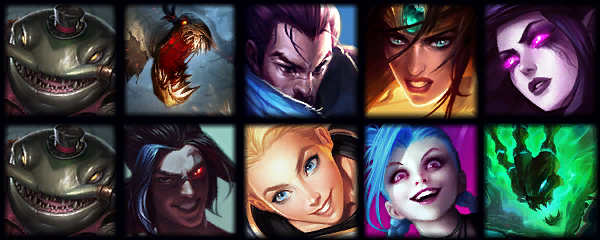

In [43]:
comps_img = begin
    #using ImageView

    grps = @chain megaPostmatchDf begin
        transform(:puuid => ByRow(x-> x in puuids) => :analyze) #preprocess
        sort([:analyze,:win];rev=true,view=false,alg=Base.Sort.InsertionSort) #fast sort
        groupby([:matchId],sort=false)
        #min team members
        filter( x-> (sum(x[1:5,:analyze])>=4), _)
        DataFrame #HERE WE CAN FILTER CHAMP FREQ(TO BE IMPLEMENTED)
        #order
        sort([:teamPosition])
        #subset(:puuid => ByRow(x->x in puuids)) DEPRECATED
        #get rid of fill players
        subset([:myTeamId,:teamId] => ByRow((x,y) -> (x==y)))
        #clean championIds
        transform([:championId,:puuid] => ByRow((x,p)-> ((p in puuids) ? x : -1)) => :championId)
        groupby(:matchId)
        #vscodedisplay
    end

    #vscodedisplay(grps[keys(grps)[1]][!,[:teamPosition,:participantId]])
    #icons path
    iconspath = "./assets/icons/"
    cids = []

    for k in keys(grps)
        push!(cids,collect(grps[k].championId))
    end
    cids
    # for (i,x) in enumerate(cids)
    #     cids[i] = map(v -> iconspath * string(v) * ".png",x)
    # end
    for (i,x) in enumerate(cids)
        cids[i] = DataFrame(permutedims(x),:auto)
    end
    cids = reduce(vcat,cids)
    transform!(cids, :x1 => :x4, :x4=>:x1)
    function cluster(df::DataFrame,indices::Array{String})
        idx = 0
        cm = 0
        out = ""
        if length(indices) == 1
            return indices[1]
        end
        for (i,index) in enumerate(indices)
            m = max(combine(groupby(df,index),nrow)[!,:nrow]...)
            if m > cm
                idx = i
                cm = m
                out = index
            end

        end
        res = cluster(df,deleteat!(indices,idx))
        return [out; res]
    end
    sort!(cids,cluster(cids,names(cids)))
    #= imgs = similar(cids)
    for (i,cid) in enumerate(cids)
        imgs[i] = hcat(map(x->load(x),cid)...)
    end
    imgs = vcat(imgs...) =#
    imgs = []
    for row in eachrow(load.(iconspath .* string.(cids) .* ".png"))
        push!(imgs,hcat(row...))
    end
    vcat(imgs...)   
end

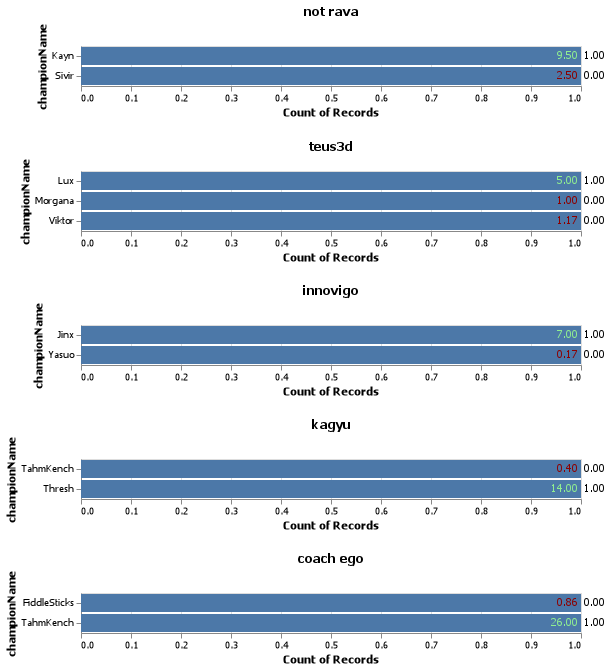

In [44]:
begin
    #PARAMS
    minCount = min(
        3 ,  min(transform(groupby(filter(x->x.puuid in puuids , megaPostmatchDf[!,[:puuid,:championName]]),[:puuid,:championName]),nrow => :count)[!,:count]...)

    )
    #END


    local data = @chain megaPostmatchDf begin 
        transform([:kills,:deaths,:assists] => ByRow((k,d,a) -> (k+a)/(d==0 ? 1 : d)) => :kda)
        filter( x-> x.puuid in puuids, _)
        groupby([:puuid,:championName])
        transform(nrow => :count)
        filter(:count => x-> x>=(minCount),_)
        transform(:gameDuration => x->x/60, renamecols = false)
        groupby(:puuid)
        collect
        
    end;
    a = []
    resize!(a,5)
    for i in 1:5
        a[i] = data[i] |>
        @vlplot(
            width=500,
            title = id2name[data[i].puuid[1]],
            y = {field = :championName},
            x = {field = :championName, aggregate = "count"},
            tooltip = [
                {
                field = :kills, type = "quantitative", aggregate = "mean"
                },
                {
                field = :deaths, type = "quantitative", aggregate = "mean"
                },
                {
                field = :assists, type = "quantitative", aggregate = "mean"
                },
                {
                field = :gameDuration, type = "quantitative", aggregate = "mean"
                },
                {
                field = :turretTakedowns, type = "quantitative", aggregate = "mean"
                },
                {
                field = :totalMinionsKilled, type = "quantitative", aggregate = "mean"
                },
                {
                field = :neutralMinionsKilled, type = "quantitative", aggregate = "mean"
                },
                {
                field = :visionScore, type = "quantitative", aggregate = "mean"
                },
                {
                field = :firstTowerKill, type = "quantitative", aggregate = "mean"
                },
                {
                field = :individualPosition, type = "nominal", aggregate = "max"
                },
                {
                field = "count", type = "quantitative"
                }
            ],
            layer = [{
                mark={
                    type=:bar
                }
                },{
                mark = {type = :text,
                        align = "left",
                        baseline = "middle",
                        dx = 3,
                        },
                encoding = {
                    text = {field = :win, aggregate = "mean", type="quantitative",format = ".2f"},
                }
                },{
                
                transform = [
                    {
                    aggregate = [{op = "mean",field = "kda", as = "kda"}],
                    groupby = ["championName"]
                }
                ],
                mark = {type = :text,
                        align = "right",
                        baseline = "middle",
                        dx = -3,
                        tooltip = "KDA"
                        },
                encoding = {
                    text = {field = :kda, type="quantitative",format = ".2f"},
                    color={
                        
                        condition = {
                            test = "datum['kda'] > 3.0",
                            value = "lightgreen"
                        }
                        ,
                        value="darkred",
                    }
                    
                },
                
            }]

        )
    end
    pool = reduce(vcat,a) 
    save(path*"pool.html",pool)
    pool
end

In [45]:
playersTL = @chain megaTimelineDf begin
	subset(:puuid => ByRow(x-> x in puuids))
	transform([:puuid] => ByRow(x->id2name[x]), renamecols = false)
	transform( :timestamp => x->x/60/1000, renamecols = false)
end;

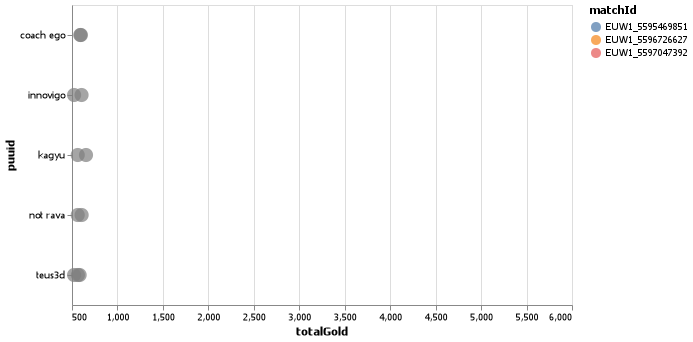

In [46]:
asd = @vlplot(
  data = playersTL[!,[:timestamp,:puuid,:matchId,
	:totalGold,
]],
    height = 300,
    width = 500,
	params = [
		{
		name = "selTimestamp",
        value = 2,
		bind = {
			input = "range", min= 1, max= 15, step= 1
			}
		}
	],
    selection = {
        selected = {
            type = "single",
            fields = [:matchId,],
			clear = "dblclick"
        }
    },
	transform = [
		{
		filter = {field = :timestamp, equal = {expr = "selTimestamp"}}
		},
	],
	mark = {
		type = :circle,
        size = 200
	},
	encoding = {
		x = {
            field = :totalGold,
            scale = {domain = [500,6000]}
        },
		y = {field = :puuid, type = "nominal"},
        color = {
            condition = {
                selection = {not = "selected"},
                value = "grey",
				},
            field = [:matchId],
			type = "nominal"
        },
	}
)

In [47]:
asd |> save(path * "goldPlot.html")

In [48]:
fhdf = @chain megaPostmatchDf begin
    filter(x->x.puuid in puuids, _)
    transform(:puuid => ByRow(x-> id2name[x]); renamecols=false)
end;

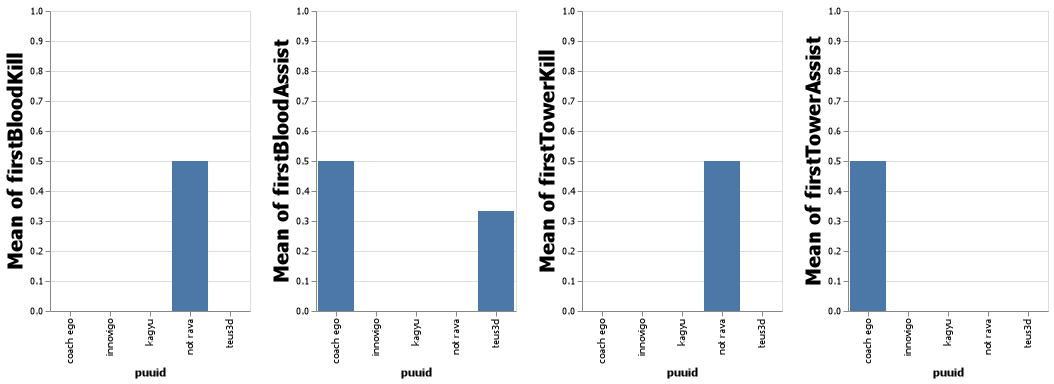

In [49]:
firstHist = fhdf |> @vlplot(repeat={column=[:firstBloodKill, :firstBloodAssist, :firstTowerKill, :firstTowerAssist]}
) + @vlplot(
    width = 200,
    height = 300,
    mark = {:bar},
    encoding = {
        x = {
            field = :puuid, type = "nominal"
        },
        y ={
            field = {repeat = :column}, type = "quantitative" , aggregate = "mean",
            scale = {
                domain = [0,1],
            },
            axis = {
                titleFontSize = 20,
                labelFontSize = 10
            },
        },
        tooltip = {
            aggregate = "count", type = "quantitative", title = "N°"
			},
        
        
    }
)

In [50]:
firstHist |> save(path * "firsthist.html")

In [51]:
#begin
#	ENV["COLUMNS"] = 3000
#	ENV["LINES"] = 20
#end

In [52]:
function enemyPID2POSITION(matchId,victimId)
	filt = (megaPostmatchDf[!,[:matchId]] .== matchId .&& megaPostmatchDf[!,:participantId] .== victimId)
	megaPostmatchDf[filt[!,1],:teamPosition]
end

enemyPID2POSITION (generic function with 1 method)

In [53]:
firstBloodDf = @chain megaEventsDf begin
	subset(:type => ByRow(x->x=="CHAMPION_KILL"), skipmissing = true)
	_[!,Not([:victimDamageReceived,:victimDamageDealt])]
	select(_, [all(!ismissing,_[!,col]) ? true : false for col in names(_)])
	begin
		emptydf = DataFrame()
		counter = 0
		for row in eachrow(_)
			tid = row.myTeamId
			if  tid == 100
				if 0 < row.killerId <= 5
					push!(emptydf,row)
				end
			else
				if 10 >= row.killerId > 5
					push!(emptydf,row)
				end
			end
		end
		sort(emptydf,[:matchId,:timestamp])
	end
	groupby(:matchId)
	map(x->first(x,2),collect(_))
	vcat(_...)
	transform([:matchId,:victimId] => ByRow((x,y)-> enemyPID2POSITION(x,y)) => [:approxDeathLane])
	#transform([:victimId] => ByRow(x-> x >5 ? x-5 : x); renamecols=false)
	transform(:approxDeathLane => ByRow( x -> (x=="UTILITY" ? "BOTTOM" : x) ) ; renamecols = false)
end;

In [54]:
firstBloodDf[!,:timestamp] = firstBloodDf[!,:timestamp]/1000/60;

In [55]:
firstBloodDf;

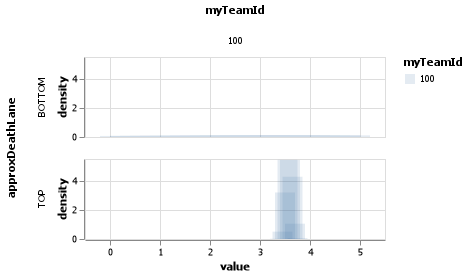

In [56]:
#=
Abbiamo tutte le first blood dei giocatori del team in esame.
Voglio sapere quando le fanno e dove le fanno per determinare la lane più gankata.
assistingPartcipantsIds -> teamPosition
killerId -> teamPosition
Ma forse non ci serve la firstBlood, in realtà vogliamo sapere quali sono le lane più gankate e quando
=#
ganksWithKillsHist = @vlplot(
	width = 300,
	height = 80,
	transform = [
    {
      density = :timestamp,
      groupby = [:approxDeathLane,:myTeamId],
      extent = [0, 5]
    }
  	],
	data = firstBloodDf,
	mark = {
		type=:bar,
		size = 20,
		opacity=0.15,
		tooltip = true
	},
	encoding = {
		x = {
			field = "value",
			type = "Q"
		},
		y = {
			field = "density",
			type = "quantitative",
			stack = "zero"
		},
		color = {
			field = :myTeamId,
			type = "nominal"
		},
		row = {
			field = :approxDeathLane,
			type = "N"
		},
		column = {
			field = :myTeamId,
			type = "N"
		}
	}
)

In [57]:
ganksWithKillsHist |> save(path*"ganksWithKillsHist.html")

In [58]:
megaPositionDf = @chain megaTimelineDf[!,[:participantId,:x,:y,:myTeamId,:matchId,:timestamp,:currentGold]] begin
	filter(x-> 0+5*(x.myTeamId-100)/100< x.participantId <=5*x.myTeamId/100,_)
	transform(:timestamp => ByRow(x->x/1000/60); renamecols = false)
	transform(:y => ByRow(x->14870-x); renamecols = false)
	groupby(:matchId)
end;

In [59]:
begin
	using Clustering
	ScikitLearn.@sk_import cluster: DBSCAN
	ScikitLearn.@sk_import preprocessing: StandardScaler
	full100 = vcat(
		[filter(x->(x.myTeamId == 100 && x.timestamp < 25),
		megaPositionDf[i]) for i in 1:length(megaPositionDf)]...
	)
	full200 = vcat(
		[filter(x->(x.myTeamId == 200 && x.timestamp < 25),
		megaPositionDf[i]) for i in 1:length(megaPositionDf)]...
	)
end;

In [60]:
#timestamp_slider = @bind timeSel PlutoUI.Slider(0:1:30,1,true)

In [61]:
#=begin
	using Clustering
	full = vcat([filter(x->(true && x.timestamp < 25),megaPositionDf[i]) for i in 1:length(megaPositionDf)]...)
	tdata = vcat([filter(x->x.timestamp == timeSel,megaPositionDf[i]) for i in 1:length(megaPositionDf)]...)
	res_full = kmeans(Matrix(Matrix(full[!,[:x,:y,:timestamp,:myTeamId]])'), 20)
	res = kmeans(Matrix(Matrix(tdata[!,[:x,:y,:timestamp]])'), 6)
	res_centers = sort(DataFrame(res_full.centers',[:x,:y,:timestamp,:myTeamId]),:timestamp)


	ScikitLearn.@sk_import cluster: DBSCAN
	ScikitLearn.@sk_import preprocessing: StandardScaler
	
	training_data_sk = begin
		begin
			Xes = tdata[!,[:x,:y]]
			Xes[!,:y] = 14870 .- Xes[!,:y]
			Xes
		end;
		scaler = StandardScaler()
		mapper = ScikitLearn.DataFrameMapper([([:x,:y], scaler)]);
		training_data_sk = ScikitLearn.fit_transform!(mapper, copy(Xes))
	end

	training_data_sk_full = begin
		begin
			Xes_full = full[!,[:x,:y,:timestamp]]
			Xes_full[!,:y] = 14870 .- Xes_full[!,:y]
			Xes_full
		end;
		scaler_full = StandardScaler()
		mapper_full = ScikitLearn.DataFrameMapper([([:x,:y,:timestamp], scaler)]);
		mapper_full = ScikitLearn.fit!(mapper_full, copy(Xes_full))
		training_data_sk_full = ScikitLearn.transform(mapper_full, copy(Xes_full))
	end
end;=#

In [62]:
cluster_size_coeff = 9 /l;

In [63]:
maximum_distance = @bind eps  PlutoUI.Slider(0.15:0.001:0.3,0.25,true)

PlutoUI.BuiltinsNotebook.Slider{Float64}(0.15:0.001:0.3, 0.25, true)

In [64]:
#=begin
	mappa =load("./assets/map11.png")
	local color1 = 0
	for grp in megaPositionDf
		color1 += 1/length(megaPositionDf)
		for el in eachrow(grp)
			if el.timestamp == timeSel
				coord = xy2coord(el.x,el.y)
				if el.myTeamId == 100
					color = 1
				else
					color = 0
				end
				draw!(mappa,Ellipse(CirclePointRadius(coord[:x],coord[:y],6)),RGB{N0f8}(1-color1,color,color1))
			end
		end
	end
	for col_idx in 1:size(res.centers)[2]
		coord = xy2coord(res.centers[1,col_idx],res.centers[2,col_idx])
		#@show coord
		draw!(mappa,Ellipse(CirclePointRadius(coord[:x],coord[:y],20)),RGB{N0f8}(1,1,1))
	end
	mappa
	mappa
end=#
#=begin
	dbscan = DBSCAN(eps=eps,min_samples = l*cluster_size_coeff)
	ScikitLearn.fit!(dbscan, training_data_sk)
	y_pred = dbscan.labels_
end;=#
#= hcat(DataFrame(training_data_sk,[:x,:y]),DataFrame(pred = y_pred)) |> @vlplot(
	mark = "point",
	x = :x,
	y = :y,
	color = {
		field = :pred,
 		type = "nominal"
	}
)=#
#[(label,count(x->x==label,y_pred)) for label in unique(y_pred)]
#=begin
	dbscan_full = DBSCAN(eps=0.13,min_samples = 4)
	ScikitLearn.fit!(dbscan_full, training_data_sk_full)
	y_pred_full = dbscan_full.labels_
	dbscan_centers = ScikitLearn.inverse_transform(mapper_full.features[1][2],dbscan_full.components_)
end=#
 #=hcat(DataFrame(training_data_sk_full,[:x,:y,:timestamp]),DataFrame(pred = y_pred_full)) |> @vlplot(
	mark = "point",
	x = :x,
	y = :y,
	color = {
		field = :pred,
 		type = "nominal"
	}
 )=#
#=DataFrame(dbscan_centers,[:x,:y,:timestamp]) |> @vlplot(
	transform = [
		{
			filter = {
				field = :timestamp,
				range = [6,9]
			}
		}
	],
	mark = {
		type = "circle",
		size = 100,
		opacity = 0.4
	},
	x = :x,
	y = :y,
	color = {
		field = :timestamp,
 		type = "nominal"
	}
)=#

In [65]:
begin
	posPredDfs_100 = []
	grps_100 = groupby(full100,[:timestamp])
	groupnames = keys(grps_100)
	for (i,grp) in enumerate(grps_100)
		training_data_sk = begin
			Xes = begin
				Xes = copy(grp[!,[:x,:y]])
				Xes[!,:y] = 14870 .- Xes[!,:y]
				Xes
			end;
			scaler = StandardScaler()
			mapper = ScikitLearn.DataFrameMapper([([:x,:y], scaler)]);
			training_data_sk = ScikitLearn.fit_transform!(mapper, copy(Xes))
		end
		dbscan = DBSCAN(eps=eps,min_samples = l*cluster_size_coeff)
		ScikitLearn.fit!(dbscan, training_data_sk)
		y_pred = dbscan.labels_
		grp = hcat(Xes,DataFrame(pred = y_pred, timestamp = groupnames[i][1]))
		push!(posPredDfs_100,grp)
	end

	posPredDfs_200 = []
	grps_200 = groupby(full200,[:timestamp])
	groupnames = keys(grps_200)
	for (i,grp) in enumerate(grps_200)
		training_data_sk = begin
			Xes = begin
				Xes = copy(grp[!,[:x,:y]])
				Xes[!,:y] = 14870 .- Xes[!,:y]
				Xes
			end;
			scaler = StandardScaler()
			mapper = ScikitLearn.DataFrameMapper([([:x,:y], scaler)]);
			training_data_sk = ScikitLearn.fit_transform!(mapper, copy(Xes))
		end
		dbscan = DBSCAN(eps=eps,min_samples = l*cluster_size_coeff)
		ScikitLearn.fit!(dbscan, training_data_sk)
		y_pred = dbscan.labels_
		grp = hcat(Xes,DataFrame(pred = y_pred, timestamp = groupnames[i][1]))
		push!(posPredDfs_200,grp)
	end
end

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\Coffee\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


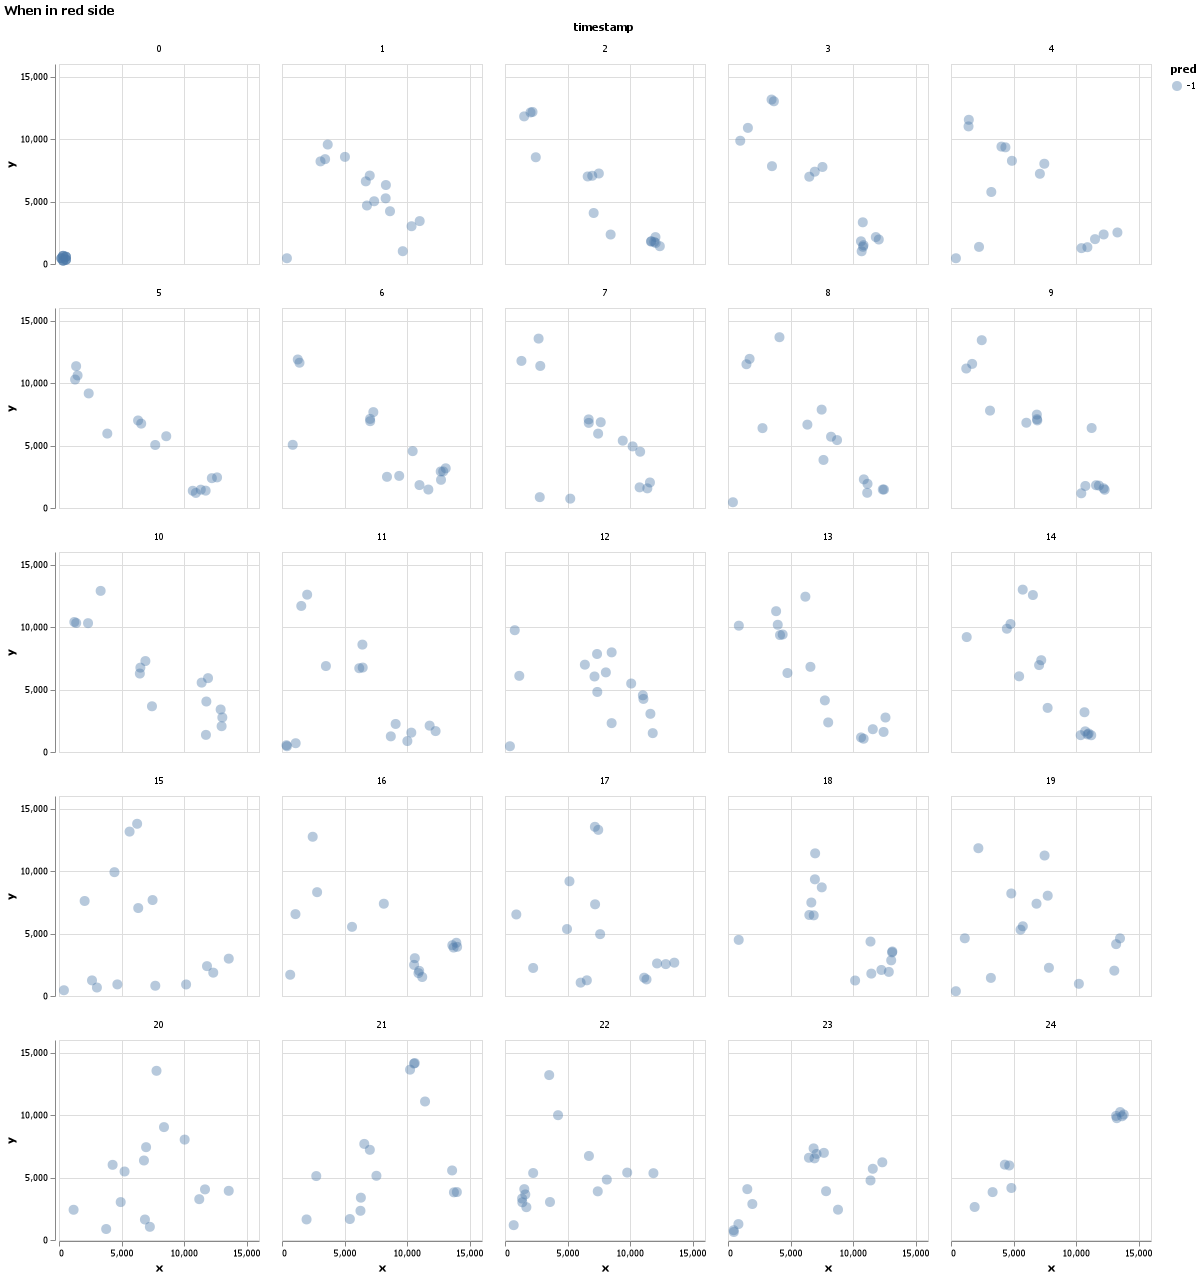

In [66]:
if size(posPredDfs_100)[1]!=0
    pos100 = vcat(posPredDfs_100...) |> @vlplot(
        title = "When in red side",
        mark = {
            type = :circle,
            size = 100,
            opacity = 0.4
        },
        encoding = {
            x = {
                field = :x,
                type = "Q"
            },
            y = {
                field = :y,
                type = "Q"
            },
            color = {
                field = :pred,
                type = "N"
            },
            facet = {
                field = [:timestamp],
                type = "ordinal",
                columns = 5
            }
        }

    )
end

In [67]:
if size(posPredDfs_100)[1]!=0
    pos100 |> save(path*"pos100.html")
end

In [68]:
if size(posPredDfs_200)[1]!=0
    pos200 = vcat(posPredDfs_200...) |> @vlplot(
        title = "When in red side",
        mark = {
            type = :circle,
            size = 100,
            opacity = 0.4
        },
        encoding = {
            x = {
                field = :x,
                type = "Q"
            },
            y = {
                field = :y,
                type = "Q"
            },
            color = {
                field = :pred,
                type = "N"
            },
            facet = {
                field = [:timestamp],
                type = "ordinal",
                columns = 5
            }
        }

    )
end

In [69]:
if size(posPredDfs_200)[1]!=0
    pos200 |> save(path*"pos200.html")
end

In [70]:
PLUTO_PROJECT_TOML_CONTENTS = """
[deps]
CSV = "336ed68f-0bac-5ca0-87d4-7b16caf5d00b"
Chain = "8be319e6-bccf-4806-a6f7-6fae938471bc"
Clustering = "aaaa29a8-35af-508c-8bc3-b662a17a0fe5"
DataFrames = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
DataFramesMeta = "1313f7d8-7da2-5740-9ea0-a2ca25f37964"
Distributed = "8ba89e20-285c-5b6f-9357-94700520ee1b"
FileIO = "5789e2e9-d7fb-5bc7-8068-2c6fae9b9549"
HTTP = "cd3eb016-35fb-5094-929b-558a96fad6f3"
ImageDraw = "4381153b-2b60-58ae-a1ba-fd683676385f"
Images = "916415d5-f1e6-5110-898d-aaa5f9f070e0"
JSON3 = "0f8b85d8-7281-11e9-16c2-39a750bddbf1"
LOLTools = "e2c437b3-d38f-4222-8753-dddcd5679a95"
PlutoUI = "7f904dfe-b85e-4ff6-b463-dae2292396a8"
Query = "1a8c2f83-1ff3-5112-b086-8aa67b057ba1"
Random = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"
ScikitLearn = "3646fa90-6ef7-5e7e-9f22-8aca16db6324"
SharedArrays = "1a1011a3-84de-559e-8e89-a11a2f7dc383"
Statistics = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"
VegaLite = "112f6efa-9a02-5b7d-90c0-432ed331239a"

[compat]
CSV = "~0.9.11"
Chain = "~0.4.9"
Clustering = "~0.14.2"
DataFrames = "~1.3.0"
DataFramesMeta = "~0.10.0"
FileIO = "~1.11.2"
HTTP = "~0.9.17"
ImageDraw = "~0.2.5"
Images = "~0.25.0"
JSON3 = "~1.9.2"
LOLTools = "~0.1.3"
PlutoUI = "~0.7.21"
Query = "~1.0.0"
ScikitLearn = "~0.6.4"
VegaLite = "~2.6.0"
"""

"[deps]\nCSV = \"336ed68f-0bac-5ca0-87d4-7b16caf5d00b\"\nChain = \"8be319e6-bccf-4806-a6f7-6fae938471bc\"\nClustering = \"aaaa29a8-35af-508c-8bc3-b662a17a0fe5\"\nDataFrames = \"a93c6f00-e57d-5684-b7b6-d8193f3e46c0\"\nDataFramesMeta = \"1313f7d8-7da2-5740-9ea0-a2ca25f37964\"\nDistributed = \"8ba89e20-285c-5b6f-9357-94700520ee1b\"\nFileIO = \"5789e2e9-d7fb-5bc7-8068-2c6fae9b9549\"\nHTTP = \"cd3eb016-35fb-5094-929b-558a96fad6f3\"\nImageDraw = \"4381153b-2b60-58ae-a1ba-fd683676385f\"\nImages = \"916415d5-f1e6-5110-898d-aaa5f9f070e0\"\nJSON3 = \"0f8b85d8-7281-11e9-16c2-39a750bddbf1\"\nLOLTools = \"e2c437b3-d38f-4222-8753-dddcd5679a95\"\nPlutoUI = \"7f904dfe-b85e-4ff6-b463-dae2292396a8\"\nQuery = \"1a8c2f83-1ff3-5112-b086-8aa67b057ba1\"\nRandom = \"9a3f8284-a2c9-5f02-9a11-845980a1fd5c\"\nScikitLearn = \"3646fa90-6ef7-5e7e-9f22-8aca16db6324\"\nSharedArrays = \"1a1011a3-84de-559e-8e89-a11a2f7dc383\"\nStatistics = \"10745b16-79ce-11e8-11f9-7d13ad32a3b2\"\nVegaLite = \"112f6efa-9a02-5b7d-90c0-43

In [71]:
PLUTO_MANIFEST_TOML_CONTENTS = """
# This file is machine-generated - editing it directly is not advised

julia_version = "1.7.0"
manifest_format = "2.0"

[[deps.AbstractFFTs]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "485ee0867925449198280d4af84bdb46a2a404d0"
uuid = "621f4979-c628-5d54-868e-fcf4e3e8185c"
version = "1.0.1"

[[deps.AbstractPlutoDingetjes]]
deps = ["Pkg"]
git-tree-sha1 = "abb72771fd8895a7ebd83d5632dc4b989b022b5b"
uuid = "6e696c72-6542-2067-7265-42206c756150"
version = "1.1.2"

[[deps.Adapt]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "84918055d15b3114ede17ac6a7182f68870c16f7"
uuid = "79e6a3ab-5dfb-504d-930d-738a2a938a0e"
version = "3.3.1"

[[deps.ArgTools]]
uuid = "0dad84c5-d112-42e6-8d28-ef12dabb789f"

[[deps.ArnoldiMethod]]
deps = ["LinearAlgebra", "Random", "StaticArrays"]
git-tree-sha1 = "62e51b39331de8911e4a7ff6f5aaf38a5f4cc0ae"
uuid = "ec485272-7323-5ecc-a04f-4719b315124d"
version = "0.2.0"

[[deps.ArrayInterface]]
deps = ["Compat", "IfElse", "LinearAlgebra", "Requires", "SparseArrays", "Static"]
git-tree-sha1 = "265b06e2b1f6a216e0e8f183d28e4d354eab3220"
uuid = "4fba245c-0d91-5ea0-9b3e-6abc04ee57a9"
version = "3.2.1"

[[deps.Artifacts]]
uuid = "56f22d72-fd6d-98f1-02f0-08ddc0907c33"

[[deps.AxisAlgorithms]]
deps = ["LinearAlgebra", "Random", "SparseArrays", "WoodburyMatrices"]
git-tree-sha1 = "66771c8d21c8ff5e3a93379480a2307ac36863f7"
uuid = "13072b0f-2c55-5437-9ae7-d433b7a33950"
version = "1.0.1"

[[deps.AxisArrays]]
deps = ["Dates", "IntervalSets", "IterTools", "RangeArrays"]
git-tree-sha1 = "d127d5e4d86c7680b20c35d40b503c74b9a39b5e"
uuid = "39de3d68-74b9-583c-8d2d-e117c070f3a9"
version = "0.4.4"

[[deps.Base64]]
uuid = "2a0f44e3-6c83-55bd-87e4-b1978d98bd5f"

[[deps.CEnum]]
git-tree-sha1 = "215a9aa4a1f23fbd05b92769fdd62559488d70e9"
uuid = "fa961155-64e5-5f13-b03f-caf6b980ea82"
version = "0.4.1"

[[deps.CSV]]
deps = ["CodecZlib", "Dates", "FilePathsBase", "InlineStrings", "Mmap", "Parsers", "PooledArrays", "SentinelArrays", "Tables", "Unicode", "WeakRefStrings"]
git-tree-sha1 = "49f14b6c56a2da47608fe30aed711b5882264d7a"
uuid = "336ed68f-0bac-5ca0-87d4-7b16caf5d00b"
version = "0.9.11"

[[deps.Calculus]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "f641eb0a4f00c343bbc32346e1217b86f3ce9dad"
uuid = "49dc2e85-a5d0-5ad3-a950-438e2897f1b9"
version = "0.5.1"

[[deps.CatIndices]]
deps = ["CustomUnitRanges", "OffsetArrays"]
git-tree-sha1 = "a0f80a09780eed9b1d106a1bf62041c2efc995bc"
uuid = "aafaddc9-749c-510e-ac4f-586e18779b91"
version = "0.2.2"

[[deps.Chain]]
git-tree-sha1 = "06fb4f12fc35c9048a52d5b79c64e1d736a228c7"
uuid = "8be319e6-bccf-4806-a6f7-6fae938471bc"
version = "0.4.9"

[[deps.ChainRulesCore]]
deps = ["Compat", "LinearAlgebra", "SparseArrays"]
git-tree-sha1 = "4c26b4e9e91ca528ea212927326ece5918a04b47"
uuid = "d360d2e6-b24c-11e9-a2a3-2a2ae2dbcce4"
version = "1.11.2"

[[deps.ChangesOfVariables]]
deps = ["LinearAlgebra", "Test"]
git-tree-sha1 = "9a1d594397670492219635b35a3d830b04730d62"
uuid = "9e997f8a-9a97-42d5-a9f1-ce6bfc15e2c0"
version = "0.1.1"

[[deps.Clustering]]
deps = ["Distances", "LinearAlgebra", "NearestNeighbors", "Printf", "SparseArrays", "Statistics", "StatsBase"]
git-tree-sha1 = "75479b7df4167267d75294d14b58244695beb2ac"
uuid = "aaaa29a8-35af-508c-8bc3-b662a17a0fe5"
version = "0.14.2"

[[deps.CodecZlib]]
deps = ["TranscodingStreams", "Zlib_jll"]
git-tree-sha1 = "ded953804d019afa9a3f98981d99b33e3db7b6da"
uuid = "944b1d66-785c-5afd-91f1-9de20f533193"
version = "0.7.0"

[[deps.ColorTypes]]
deps = ["FixedPointNumbers", "Random"]
git-tree-sha1 = "024fe24d83e4a5bf5fc80501a314ce0d1aa35597"
uuid = "3da002f7-5984-5a60-b8a6-cbb66c0b333f"
version = "0.11.0"

[[deps.ColorVectorSpace]]
deps = ["ColorTypes", "FixedPointNumbers", "LinearAlgebra", "SpecialFunctions", "Statistics", "TensorCore"]
git-tree-sha1 = "3f1f500312161f1ae067abe07d13b40f78f32e07"
uuid = "c3611d14-8923-5661-9e6a-0046d554d3a4"
version = "0.9.8"

[[deps.Colors]]
deps = ["ColorTypes", "FixedPointNumbers", "Reexport"]
git-tree-sha1 = "417b0ed7b8b838aa6ca0a87aadf1bb9eb111ce40"
uuid = "5ae59095-9a9b-59fe-a467-6f913c188581"
version = "0.12.8"

[[deps.Compat]]
deps = ["Base64", "Dates", "DelimitedFiles", "Distributed", "InteractiveUtils", "LibGit2", "Libdl", "LinearAlgebra", "Markdown", "Mmap", "Pkg", "Printf", "REPL", "Random", "SHA", "Serialization", "SharedArrays", "Sockets", "SparseArrays", "Statistics", "Test", "UUIDs", "Unicode"]
git-tree-sha1 = "dce3e3fea680869eaa0b774b2e8343e9ff442313"
uuid = "34da2185-b29b-5c13-b0c7-acf172513d20"
version = "3.40.0"

[[deps.CompilerSupportLibraries_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "e66e0078-7015-5450-92f7-15fbd957f2ae"

[[deps.ComputationalResources]]
git-tree-sha1 = "52cb3ec90e8a8bea0e62e275ba577ad0f74821f7"
uuid = "ed09eef8-17a6-5b46-8889-db040fac31e3"
version = "0.3.2"

[[deps.Conda]]
deps = ["Downloads", "JSON", "VersionParsing"]
git-tree-sha1 = "6cdc8832ba11c7695f494c9d9a1c31e90959ce0f"
uuid = "8f4d0f93-b110-5947-807f-2305c1781a2d"
version = "1.6.0"

[[deps.ConstructionBase]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "f74e9d5388b8620b4cee35d4c5a618dd4dc547f4"
uuid = "187b0558-2788-49d3-abe0-74a17ed4e7c9"
version = "1.3.0"

[[deps.CoordinateTransformations]]
deps = ["LinearAlgebra", "StaticArrays"]
git-tree-sha1 = "681ea870b918e7cff7111da58791d7f718067a19"
uuid = "150eb455-5306-5404-9cee-2592286d6298"
version = "0.6.2"

[[deps.Crayons]]
git-tree-sha1 = "3f71217b538d7aaee0b69ab47d9b7724ca8afa0d"
uuid = "a8cc5b0e-0ffa-5ad4-8c14-923d3ee1735f"
version = "4.0.4"

[[deps.CustomUnitRanges]]
git-tree-sha1 = "1a3f97f907e6dd8983b744d2642651bb162a3f7a"
uuid = "dc8bdbbb-1ca9-579f-8c36-e416f6a65cce"
version = "1.0.2"

[[deps.DataAPI]]
git-tree-sha1 = "cc70b17275652eb47bc9e5f81635981f13cea5c8"
uuid = "9a962f9c-6df0-11e9-0e5d-c546b8b5ee8a"
version = "1.9.0"

[[deps.DataFrames]]
deps = ["Compat", "DataAPI", "Future", "InvertedIndices", "IteratorInterfaceExtensions", "LinearAlgebra", "Markdown", "Missings", "PooledArrays", "PrettyTables", "Printf", "REPL", "Reexport", "SortingAlgorithms", "Statistics", "TableTraits", "Tables", "Unicode"]
git-tree-sha1 = "2e993336a3f68216be91eb8ee4625ebbaba19147"
uuid = "a93c6f00-e57d-5684-b7b6-d8193f3e46c0"
version = "1.3.0"

[[deps.DataFramesMeta]]
deps = ["Chain", "DataFrames", "MacroTools", "OrderedCollections", "Reexport"]
git-tree-sha1 = "ab4768d2cc6ab000cd0cec78e8e1ea6b03c7c3e2"
uuid = "1313f7d8-7da2-5740-9ea0-a2ca25f37964"
version = "0.10.0"

[[deps.DataStructures]]
deps = ["Compat", "InteractiveUtils", "OrderedCollections"]
git-tree-sha1 = "7d9d316f04214f7efdbb6398d545446e246eff02"
uuid = "864edb3b-99cc-5e75-8d2d-829cb0a9cfe8"
version = "0.18.10"

[[deps.DataValueInterfaces]]
git-tree-sha1 = "bfc1187b79289637fa0ef6d4436ebdfe6905cbd6"
uuid = "e2d170a0-9d28-54be-80f0-106bbe20a464"
version = "1.0.0"

[[deps.DataValues]]
deps = ["DataValueInterfaces", "Dates"]
git-tree-sha1 = "d88a19299eba280a6d062e135a43f00323ae70bf"
uuid = "e7dc6d0d-1eca-5fa6-8ad6-5aecde8b7ea5"
version = "0.4.13"

[[deps.Dates]]
deps = ["Printf"]
uuid = "ade2ca70-3891-5945-98fb-dc099432e06a"

[[deps.DelimitedFiles]]
deps = ["Mmap"]
uuid = "8bb1440f-4735-579b-a4ab-409b98df4dab"

[[deps.Distances]]
deps = ["LinearAlgebra", "SparseArrays", "Statistics", "StatsAPI"]
git-tree-sha1 = "3258d0659f812acde79e8a74b11f17ac06d0ca04"
uuid = "b4f34e82-e78d-54a5-968a-f98e89d6e8f7"
version = "0.10.7"

[[deps.Distributed]]
deps = ["Random", "Serialization", "Sockets"]
uuid = "8ba89e20-285c-5b6f-9357-94700520ee1b"

[[deps.DocStringExtensions]]
deps = ["LibGit2"]
git-tree-sha1 = "b19534d1895d702889b219c382a6e18010797f0b"
uuid = "ffbed154-4ef7-542d-bbb7-c09d3a79fcae"
version = "0.8.6"

[[deps.Downloads]]
deps = ["ArgTools", "LibCURL", "NetworkOptions"]
uuid = "f43a241f-c20a-4ad4-852c-f6b1247861c6"

[[deps.DualNumbers]]
deps = ["Calculus", "NaNMath", "SpecialFunctions"]
git-tree-sha1 = "84f04fe68a3176a583b864e492578b9466d87f1e"
uuid = "fa6b7ba4-c1ee-5f82-b5fc-ecf0adba8f74"
version = "0.6.6"

[[deps.EllipsisNotation]]
deps = ["ArrayInterface"]
git-tree-sha1 = "3fe985505b4b667e1ae303c9ca64d181f09d5c05"
uuid = "da5c29d0-fa7d-589e-88eb-ea29b0a81949"
version = "1.1.3"

[[deps.FFTViews]]
deps = ["CustomUnitRanges", "FFTW"]
git-tree-sha1 = "cbdf14d1e8c7c8aacbe8b19862e0179fd08321c2"
uuid = "4f61f5a4-77b1-5117-aa51-3ab5ef4ef0cd"
version = "0.3.2"

[[deps.FFTW]]
deps = ["AbstractFFTs", "FFTW_jll", "LinearAlgebra", "MKL_jll", "Preferences", "Reexport"]
git-tree-sha1 = "463cb335fa22c4ebacfd1faba5fde14edb80d96c"
uuid = "7a1cc6ca-52ef-59f5-83cd-3a7055c09341"
version = "1.4.5"

[[deps.FFTW_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "c6033cc3892d0ef5bb9cd29b7f2f0331ea5184ea"
uuid = "f5851436-0d7a-5f13-b9de-f02708fd171a"
version = "3.3.10+0"

[[deps.FileIO]]
deps = ["Pkg", "Requires", "UUIDs"]
git-tree-sha1 = "2db648b6712831ecb333eae76dbfd1c156ca13bb"
uuid = "5789e2e9-d7fb-5bc7-8068-2c6fae9b9549"
version = "1.11.2"

[[deps.FilePaths]]
deps = ["FilePathsBase", "MacroTools", "Reexport", "Requires"]
git-tree-sha1 = "919d9412dbf53a2e6fe74af62a73ceed0bce0629"
uuid = "8fc22ac5-c921-52a6-82fd-178b2807b824"
version = "0.8.3"

[[deps.FilePathsBase]]
deps = ["Compat", "Dates", "Mmap", "Printf", "Test", "UUIDs"]
git-tree-sha1 = "04d13bfa8ef11720c24e4d840c0033d145537df7"
uuid = "48062228-2e41-5def-b9a4-89aafe57970f"
version = "0.9.17"

[[deps.FixedPointNumbers]]
deps = ["Statistics"]
git-tree-sha1 = "335bfdceacc84c5cdf16aadc768aa5ddfc5383cc"
uuid = "53c48c17-4a7d-5ca2-90c5-79b7896eea93"
version = "0.8.4"

[[deps.Formatting]]
deps = ["Printf"]
git-tree-sha1 = "8339d61043228fdd3eb658d86c926cb282ae72a8"
uuid = "59287772-0a20-5a39-b81b-1366585eb4c0"
version = "0.4.2"

[[deps.Future]]
deps = ["Random"]
uuid = "9fa8497b-333b-5362-9e8d-4d0656e87820"

[[deps.Graphics]]
deps = ["Colors", "LinearAlgebra", "NaNMath"]
git-tree-sha1 = "1c5a84319923bea76fa145d49e93aa4394c73fc2"
uuid = "a2bd30eb-e257-5431-a919-1863eab51364"
version = "1.1.1"

[[deps.Graphs]]
deps = ["ArnoldiMethod", "DataStructures", "Distributed", "Inflate", "LinearAlgebra", "Random", "SharedArrays", "SimpleTraits", "SparseArrays", "Statistics"]
git-tree-sha1 = "92243c07e786ea3458532e199eb3feee0e7e08eb"
uuid = "86223c79-3864-5bf0-83f7-82e725a168b6"
version = "1.4.1"

[[deps.HTTP]]
deps = ["Base64", "Dates", "IniFile", "Logging", "MbedTLS", "NetworkOptions", "Sockets", "URIs"]
git-tree-sha1 = "0fa77022fe4b511826b39c894c90daf5fce3334a"
uuid = "cd3eb016-35fb-5094-929b-558a96fad6f3"
version = "0.9.17"

[[deps.Hyperscript]]
deps = ["Test"]
git-tree-sha1 = "8d511d5b81240fc8e6802386302675bdf47737b9"
uuid = "47d2ed2b-36de-50cf-bf87-49c2cf4b8b91"
version = "0.0.4"

[[deps.HypertextLiteral]]
git-tree-sha1 = "2b078b5a615c6c0396c77810d92ee8c6f470d238"
uuid = "ac1192a8-f4b3-4bfe-ba22-af5b92cd3ab2"
version = "0.9.3"

[[deps.IOCapture]]
deps = ["Logging", "Random"]
git-tree-sha1 = "f7be53659ab06ddc986428d3a9dcc95f6fa6705a"
uuid = "b5f81e59-6552-4d32-b1f0-c071b021bf89"
version = "0.2.2"

[[deps.IfElse]]
git-tree-sha1 = "debdd00ffef04665ccbb3e150747a77560e8fad1"
uuid = "615f187c-cbe4-4ef1-ba3b-2fcf58d6d173"
version = "0.1.1"

[[deps.ImageAxes]]
deps = ["AxisArrays", "ImageBase", "ImageCore", "Reexport", "SimpleTraits"]
git-tree-sha1 = "c54b581a83008dc7f292e205f4c409ab5caa0f04"
uuid = "2803e5a7-5153-5ecf-9a86-9b4c37f5f5ac"
version = "0.6.10"

[[deps.ImageBase]]
deps = ["ImageCore", "Reexport"]
git-tree-sha1 = "b51bb8cae22c66d0f6357e3bcb6363145ef20835"
uuid = "c817782e-172a-44cc-b673-b171935fbb9e"
version = "0.1.5"

[[deps.ImageContrastAdjustment]]
deps = ["ImageCore", "ImageTransformations", "Parameters"]
git-tree-sha1 = "0d75cafa80cf22026cea21a8e6cf965295003edc"
uuid = "f332f351-ec65-5f6a-b3d1-319c6670881a"
version = "0.3.10"

[[deps.ImageCore]]
deps = ["AbstractFFTs", "ColorVectorSpace", "Colors", "FixedPointNumbers", "Graphics", "MappedArrays", "MosaicViews", "OffsetArrays", "PaddedViews", "Reexport"]
git-tree-sha1 = "9a5c62f231e5bba35695a20988fc7cd6de7eeb5a"
uuid = "a09fc81d-aa75-5fe9-8630-4744c3626534"
version = "0.9.3"

[[deps.ImageDistances]]
deps = ["Distances", "ImageCore", "ImageMorphology", "LinearAlgebra", "Statistics"]
git-tree-sha1 = "7a20463713d239a19cbad3f6991e404aca876bda"
uuid = "51556ac3-7006-55f5-8cb3-34580c88182d"
version = "0.2.15"

[[deps.ImageDraw]]
deps = ["Distances", "ImageCore", "LinearAlgebra"]
git-tree-sha1 = "6ed6e945d909f87c3013e391dcd3b2a56e48b331"
uuid = "4381153b-2b60-58ae-a1ba-fd683676385f"
version = "0.2.5"

[[deps.ImageFiltering]]
deps = ["CatIndices", "ComputationalResources", "DataStructures", "FFTViews", "FFTW", "ImageBase", "ImageCore", "LinearAlgebra", "OffsetArrays", "Reexport", "SparseArrays", "StaticArrays", "Statistics", "TiledIteration"]
git-tree-sha1 = "15bd05c1c0d5dbb32a9a3d7e0ad2d50dd6167189"
uuid = "6a3955dd-da59-5b1f-98d4-e7296123deb5"
version = "0.7.1"

[[deps.ImageIO]]
deps = ["FileIO", "Netpbm", "OpenEXR", "PNGFiles", "TiffImages", "UUIDs"]
git-tree-sha1 = "a2951c93684551467265e0e32b577914f69532be"
uuid = "82e4d734-157c-48bb-816b-45c225c6df19"
version = "0.5.9"

[[deps.ImageMagick]]
deps = ["FileIO", "ImageCore", "ImageMagick_jll", "InteractiveUtils", "Libdl", "Pkg", "Random"]
git-tree-sha1 = "5bc1cb62e0c5f1005868358db0692c994c3a13c6"
uuid = "6218d12a-5da1-5696-b52f-db25d2ecc6d1"
version = "1.2.1"

[[deps.ImageMagick_jll]]
deps = ["Artifacts", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Libtiff_jll", "Pkg", "Zlib_jll", "libpng_jll"]
git-tree-sha1 = "ea2b6fd947cdfc43c6b8c15cff982533ec1f72cd"
uuid = "c73af94c-d91f-53ed-93a7-00f77d67a9d7"
version = "6.9.12+0"

[[deps.ImageMetadata]]
deps = ["AxisArrays", "ImageAxes", "ImageBase", "ImageCore"]
git-tree-sha1 = "36cbaebed194b292590cba2593da27b34763804a"
uuid = "bc367c6b-8a6b-528e-b4bd-a4b897500b49"
version = "0.9.8"

[[deps.ImageMorphology]]
deps = ["ImageCore", "LinearAlgebra", "Requires", "TiledIteration"]
git-tree-sha1 = "5581e18a74a5838bd919294a7138c2663d065238"
uuid = "787d08f9-d448-5407-9aad-5290dd7ab264"
version = "0.3.0"

[[deps.ImageQualityIndexes]]
deps = ["ImageContrastAdjustment", "ImageCore", "ImageDistances", "ImageFiltering", "OffsetArrays", "Statistics"]
git-tree-sha1 = "1d2d73b14198d10f7f12bf7f8481fd4b3ff5cd61"
uuid = "2996bd0c-7a13-11e9-2da2-2f5ce47296a9"
version = "0.3.0"

[[deps.ImageSegmentation]]
deps = ["Clustering", "DataStructures", "Distances", "Graphs", "ImageCore", "ImageFiltering", "ImageMorphology", "LinearAlgebra", "MetaGraphs", "RegionTrees", "SimpleWeightedGraphs", "StaticArrays", "Statistics"]
git-tree-sha1 = "36832067ea220818d105d718527d6ed02385bf22"
uuid = "80713f31-8817-5129-9cf8-209ff8fb23e1"
version = "1.7.0"

[[deps.ImageShow]]
deps = ["Base64", "FileIO", "ImageBase", "ImageCore", "OffsetArrays", "StackViews"]
git-tree-sha1 = "d0ac64c9bee0aed6fdbb2bc0e5dfa9a3a78e3acc"
uuid = "4e3cecfd-b093-5904-9786-8bbb286a6a31"
version = "0.3.3"

[[deps.ImageTransformations]]
deps = ["AxisAlgorithms", "ColorVectorSpace", "CoordinateTransformations", "ImageBase", "ImageCore", "Interpolations", "OffsetArrays", "Rotations", "StaticArrays"]
git-tree-sha1 = "b4b161abc8252d68b13c5cc4a5f2ba711b61fec5"
uuid = "02fcd773-0e25-5acc-982a-7f6622650795"
version = "0.9.3"

[[deps.Images]]
deps = ["Base64", "FileIO", "Graphics", "ImageAxes", "ImageBase", "ImageContrastAdjustment", "ImageCore", "ImageDistances", "ImageFiltering", "ImageIO", "ImageMagick", "ImageMetadata", "ImageMorphology", "ImageQualityIndexes", "ImageSegmentation", "ImageShow", "ImageTransformations", "IndirectArrays", "IntegralArrays", "Random", "Reexport", "SparseArrays", "StaticArrays", "Statistics", "StatsBase", "TiledIteration"]
git-tree-sha1 = "35dc1cd115c57ad705c7db9f6ef5cc14412e8f00"
uuid = "916415d5-f1e6-5110-898d-aaa5f9f070e0"
version = "0.25.0"

[[deps.Imath_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "87f7662e03a649cffa2e05bf19c303e168732d3e"
uuid = "905a6f67-0a94-5f89-b386-d35d92009cd1"
version = "3.1.2+0"

[[deps.IndirectArrays]]
git-tree-sha1 = "012e604e1c7458645cb8b436f8fba789a51b257f"
uuid = "9b13fd28-a010-5f03-acff-a1bbcff69959"
version = "1.0.0"

[[deps.Inflate]]
git-tree-sha1 = "f5fc07d4e706b84f72d54eedcc1c13d92fb0871c"
uuid = "d25df0c9-e2be-5dd7-82c8-3ad0b3e990b9"
version = "0.1.2"

[[deps.IniFile]]
deps = ["Test"]
git-tree-sha1 = "098e4d2c533924c921f9f9847274f2ad89e018b8"
uuid = "83e8ac13-25f8-5344-8a64-a9f2b223428f"
version = "0.5.0"

[[deps.InlineStrings]]
deps = ["Parsers"]
git-tree-sha1 = "ca99cac337f8e0561c6a6edeeae5bf6966a78d21"
uuid = "842dd82b-1e85-43dc-bf29-5d0ee9dffc48"
version = "1.1.0"

[[deps.IntegralArrays]]
deps = ["ColorTypes", "FixedPointNumbers", "IntervalSets"]
git-tree-sha1 = "00019244715621f473d399e4e1842e479a69a42e"
uuid = "1d092043-8f09-5a30-832f-7509e371ab51"
version = "0.1.2"

[[deps.IntelOpenMP_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "d979e54b71da82f3a65b62553da4fc3d18c9004c"
uuid = "1d5cc7b8-4909-519e-a0f8-d0f5ad9712d0"
version = "2018.0.3+2"

[[deps.InteractiveUtils]]
deps = ["Markdown"]
uuid = "b77e0a4c-d291-57a0-90e8-8db25a27a240"

[[deps.Interpolations]]
deps = ["AxisAlgorithms", "ChainRulesCore", "LinearAlgebra", "OffsetArrays", "Random", "Ratios", "Requires", "SharedArrays", "SparseArrays", "StaticArrays", "WoodburyMatrices"]
git-tree-sha1 = "61aa005707ea2cebf47c8d780da8dc9bc4e0c512"
uuid = "a98d9a8b-a2ab-59e6-89dd-64a1c18fca59"
version = "0.13.4"

[[deps.IntervalSets]]
deps = ["Dates", "EllipsisNotation", "Statistics"]
git-tree-sha1 = "3cc368af3f110a767ac786560045dceddfc16758"
uuid = "8197267c-284f-5f27-9208-e0e47529a953"
version = "0.5.3"

[[deps.InverseFunctions]]
deps = ["Test"]
git-tree-sha1 = "a7254c0acd8e62f1ac75ad24d5db43f5f19f3c65"
uuid = "3587e190-3f89-42d0-90ee-14403ec27112"
version = "0.1.2"

[[deps.InvertedIndices]]
git-tree-sha1 = "bee5f1ef5bf65df56bdd2e40447590b272a5471f"
uuid = "41ab1584-1d38-5bbf-9106-f11c6c58b48f"
version = "1.1.0"

[[deps.IrrationalConstants]]
git-tree-sha1 = "7fd44fd4ff43fc60815f8e764c0f352b83c49151"
uuid = "92d709cd-6900-40b7-9082-c6be49f344b6"
version = "0.1.1"

[[deps.IterTools]]
git-tree-sha1 = "fa6287a4469f5e048d763df38279ee729fbd44e5"
uuid = "c8e1da08-722c-5040-9ed9-7db0dc04731e"
version = "1.4.0"

[[deps.IterableTables]]
deps = ["DataValues", "IteratorInterfaceExtensions", "Requires", "TableTraits", "TableTraitsUtils"]
git-tree-sha1 = "70300b876b2cebde43ebc0df42bc8c94a144e1b4"
uuid = "1c8ee90f-4401-5389-894e-7a04a3dc0f4d"
version = "1.0.0"

[[deps.IteratorInterfaceExtensions]]
git-tree-sha1 = "a3f24677c21f5bbe9d2a714f95dcd58337fb2856"
uuid = "82899510-4779-5014-852e-03e436cf321d"
version = "1.0.0"

[[deps.JLD2]]
deps = ["DataStructures", "FileIO", "MacroTools", "Mmap", "Pkg", "Printf", "Reexport", "TranscodingStreams", "UUIDs"]
git-tree-sha1 = "46b7834ec8165c541b0b5d1c8ba63ec940723ffb"
uuid = "033835bb-8acc-5ee8-8aae-3f567f8a3819"
version = "0.4.15"

[[deps.JLLWrappers]]
deps = ["Preferences"]
git-tree-sha1 = "642a199af8b68253517b80bd3bfd17eb4e84df6e"
uuid = "692b3bcd-3c85-4b1f-b108-f13ce0eb3210"
version = "1.3.0"

[[deps.JSON]]
deps = ["Dates", "Mmap", "Parsers", "Unicode"]
git-tree-sha1 = "8076680b162ada2a031f707ac7b4953e30667a37"
uuid = "682c06a0-de6a-54ab-a142-c8b1cf79cde6"
version = "0.21.2"

[[deps.JSON2]]
deps = ["Dates", "Parsers", "Test"]
git-tree-sha1 = "dcc3c2d9bdc036677a031ea97b76925983ca1f18"
uuid = "2535ab7d-5cd8-5a07-80ac-9b1792aadce3"
version = "0.3.4"

[[deps.JSON3]]
deps = ["Dates", "Mmap", "Parsers", "StructTypes", "UUIDs"]
git-tree-sha1 = "7d58534ffb62cd947950b3aa9b993e63307a6125"
uuid = "0f8b85d8-7281-11e9-16c2-39a750bddbf1"
version = "1.9.2"

[[deps.JSONSchema]]
deps = ["HTTP", "JSON", "URIs"]
git-tree-sha1 = "2f49f7f86762a0fbbeef84912265a1ae61c4ef80"
uuid = "7d188eb4-7ad8-530c-ae41-71a32a6d4692"
version = "0.3.4"

[[deps.JpegTurbo_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "d735490ac75c5cb9f1b00d8b5509c11984dc6943"
uuid = "aacddb02-875f-59d6-b918-886e6ef4fbf8"
version = "2.1.0+0"

[[deps.LOLTools]]
deps = ["HTTP", "JSON2"]
git-tree-sha1 = "c6a312d1ca07095dc39128582ac5fb252c38c4c1"
uuid = "e2c437b3-d38f-4222-8753-dddcd5679a95"
version = "0.1.3"

[[deps.LazyArtifacts]]
deps = ["Artifacts", "Pkg"]
uuid = "4af54fe1-eca0-43a8-85a7-787d91b784e3"

[[deps.LibCURL]]
deps = ["LibCURL_jll", "MozillaCACerts_jll"]
uuid = "b27032c2-a3e7-50c8-80cd-2d36dbcbfd21"

[[deps.LibCURL_jll]]
deps = ["Artifacts", "LibSSH2_jll", "Libdl", "MbedTLS_jll", "Zlib_jll", "nghttp2_jll"]
uuid = "deac9b47-8bc7-5906-a0fe-35ac56dc84c0"

[[deps.LibGit2]]
deps = ["Base64", "NetworkOptions", "Printf", "SHA"]
uuid = "76f85450-5226-5b5a-8eaa-529ad045b433"

[[deps.LibSSH2_jll]]
deps = ["Artifacts", "Libdl", "MbedTLS_jll"]
uuid = "29816b5a-b9ab-546f-933c-edad1886dfa8"

[[deps.Libdl]]
uuid = "8f399da3-3557-5675-b5ff-fb832c97cbdb"

[[deps.Libtiff_jll]]
deps = ["Artifacts", "JLLWrappers", "JpegTurbo_jll", "Libdl", "Pkg", "Zlib_jll", "Zstd_jll"]
git-tree-sha1 = "340e257aada13f95f98ee352d316c3bed37c8ab9"
uuid = "89763e89-9b03-5906-acba-b20f662cd828"
version = "4.3.0+0"

[[deps.LinearAlgebra]]
deps = ["Libdl", "libblastrampoline_jll"]
uuid = "37e2e46d-f89d-539d-b4ee-838fcccc9c8e"

[[deps.LogExpFunctions]]
deps = ["ChainRulesCore", "ChangesOfVariables", "DocStringExtensions", "InverseFunctions", "IrrationalConstants", "LinearAlgebra"]
git-tree-sha1 = "be9eef9f9d78cecb6f262f3c10da151a6c5ab827"
uuid = "2ab3a3ac-af41-5b50-aa03-7779005ae688"
version = "0.3.5"

[[deps.Logging]]
uuid = "56ddb016-857b-54e1-b83d-db4d58db5568"

[[deps.MKL_jll]]
deps = ["Artifacts", "IntelOpenMP_jll", "JLLWrappers", "LazyArtifacts", "Libdl", "Pkg"]
git-tree-sha1 = "5455aef09b40e5020e1520f551fa3135040d4ed0"
uuid = "856f044c-d86e-5d09-b602-aeab76dc8ba7"
version = "2021.1.1+2"

[[deps.MacroTools]]
deps = ["Markdown", "Random"]
git-tree-sha1 = "3d3e902b31198a27340d0bf00d6ac452866021cf"
uuid = "1914dd2f-81c6-5fcd-8719-6d5c9610ff09"
version = "0.5.9"

[[deps.MappedArrays]]
git-tree-sha1 = "e8b359ef06ec72e8c030463fe02efe5527ee5142"
uuid = "dbb5928d-eab1-5f90-85c2-b9b0edb7c900"
version = "0.4.1"

[[deps.Markdown]]
deps = ["Base64"]
uuid = "d6f4376e-aef5-505a-96c1-9c027394607a"

[[deps.MbedTLS]]
deps = ["Dates", "MbedTLS_jll", "Random", "Sockets"]
git-tree-sha1 = "1c38e51c3d08ef2278062ebceade0e46cefc96fe"
uuid = "739be429-bea8-5141-9913-cc70e7f3736d"
version = "1.0.3"

[[deps.MbedTLS_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "c8ffd9c3-330d-5841-b78e-0817d7145fa1"

[[deps.MetaGraphs]]
deps = ["Graphs", "JLD2", "Random"]
git-tree-sha1 = "2af69ff3c024d13bde52b34a2a7d6887d4e7b438"
uuid = "626554b9-1ddb-594c-aa3c-2596fe9399a5"
version = "0.7.1"

[[deps.Missings]]
deps = ["DataAPI"]
git-tree-sha1 = "bf210ce90b6c9eed32d25dbcae1ebc565df2687f"
uuid = "e1d29d7a-bbdc-5cf2-9ac0-f12de2c33e28"
version = "1.0.2"

[[deps.Mmap]]
uuid = "a63ad114-7e13-5084-954f-fe012c677804"

[[deps.MosaicViews]]
deps = ["MappedArrays", "OffsetArrays", "PaddedViews", "StackViews"]
git-tree-sha1 = "b34e3bc3ca7c94914418637cb10cc4d1d80d877d"
uuid = "e94cdb99-869f-56ef-bcf0-1ae2bcbe0389"
version = "0.3.3"

[[deps.MozillaCACerts_jll]]
uuid = "14a3606d-f60d-562e-9121-12d972cd8159"

[[deps.NaNMath]]
git-tree-sha1 = "bfe47e760d60b82b66b61d2d44128b62e3a369fb"
uuid = "77ba4419-2d1f-58cd-9bb1-8ffee604a2e3"
version = "0.3.5"

[[deps.NearestNeighbors]]
deps = ["Distances", "StaticArrays"]
git-tree-sha1 = "16baacfdc8758bc374882566c9187e785e85c2f0"
uuid = "b8a86587-4115-5ab1-83bc-aa920d37bbce"
version = "0.4.9"

[[deps.Netpbm]]
deps = ["FileIO", "ImageCore"]
git-tree-sha1 = "18efc06f6ec36a8b801b23f076e3c6ac7c3bf153"
uuid = "f09324ee-3d7c-5217-9330-fc30815ba969"
version = "1.0.2"

[[deps.NetworkOptions]]
uuid = "ca575930-c2e3-43a9-ace4-1e988b2c1908"

[[deps.NodeJS]]
deps = ["Pkg"]
git-tree-sha1 = "905224bbdd4b555c69bb964514cfa387616f0d3a"
uuid = "2bd173c7-0d6d-553b-b6af-13a54713934c"
version = "1.3.0"

[[deps.OffsetArrays]]
deps = ["Adapt"]
git-tree-sha1 = "043017e0bdeff61cfbb7afeb558ab29536bbb5ed"
uuid = "6fe1bfb0-de20-5000-8ca7-80f57d26f881"
version = "1.10.8"

[[deps.OpenBLAS_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "Libdl"]
uuid = "4536629a-c528-5b80-bd46-f80d51c5b363"

[[deps.OpenEXR]]
deps = ["Colors", "FileIO", "OpenEXR_jll"]
git-tree-sha1 = "327f53360fdb54df7ecd01e96ef1983536d1e633"
uuid = "52e1d378-f018-4a11-a4be-720524705ac7"
version = "0.3.2"

[[deps.OpenEXR_jll]]
deps = ["Artifacts", "Imath_jll", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "923319661e9a22712f24596ce81c54fc0366f304"
uuid = "18a262bb-aa17-5467-a713-aee519bc75cb"
version = "3.1.1+0"

[[deps.OpenLibm_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "05823500-19ac-5b8b-9628-191a04bc5112"

[[deps.OpenSpecFun_jll]]
deps = ["Artifacts", "CompilerSupportLibraries_jll", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "13652491f6856acfd2db29360e1bbcd4565d04f1"
uuid = "efe28fd5-8261-553b-a9e1-b2916fc3738e"
version = "0.5.5+0"

[[deps.OrderedCollections]]
git-tree-sha1 = "85f8e6578bf1f9ee0d11e7bb1b1456435479d47c"
uuid = "bac558e1-5e72-5ebc-8fee-abe8a469f55d"
version = "1.4.1"

[[deps.PNGFiles]]
deps = ["Base64", "CEnum", "ImageCore", "IndirectArrays", "OffsetArrays", "libpng_jll"]
git-tree-sha1 = "6d105d40e30b635cfed9d52ec29cf456e27d38f8"
uuid = "f57f5aa1-a3ce-4bc8-8ab9-96f992907883"
version = "0.3.12"

[[deps.PaddedViews]]
deps = ["OffsetArrays"]
git-tree-sha1 = "646eed6f6a5d8df6708f15ea7e02a7a2c4fe4800"
uuid = "5432bcbf-9aad-5242-b902-cca2824c8663"
version = "0.5.10"

[[deps.Parameters]]
deps = ["OrderedCollections", "UnPack"]
git-tree-sha1 = "34c0e9ad262e5f7fc75b10a9952ca7692cfc5fbe"
uuid = "d96e819e-fc66-5662-9728-84c9c7592b0a"
version = "0.12.3"

[[deps.Parsers]]
deps = ["Dates"]
git-tree-sha1 = "ae4bbcadb2906ccc085cf52ac286dc1377dceccc"
uuid = "69de0a69-1ddd-5017-9359-2bf0b02dc9f0"
version = "2.1.2"

[[deps.Pkg]]
deps = ["Artifacts", "Dates", "Downloads", "LibGit2", "Libdl", "Logging", "Markdown", "Printf", "REPL", "Random", "SHA", "Serialization", "TOML", "Tar", "UUIDs", "p7zip_jll"]
uuid = "44cfe95a-1eb2-52ea-b672-e2afdf69b78f"

[[deps.PkgVersion]]
deps = ["Pkg"]
git-tree-sha1 = "a7a7e1a88853564e551e4eba8650f8c38df79b37"
uuid = "eebad327-c553-4316-9ea0-9fa01ccd7688"
version = "0.1.1"

[[deps.PlutoUI]]
deps = ["AbstractPlutoDingetjes", "Base64", "Dates", "Hyperscript", "HypertextLiteral", "IOCapture", "InteractiveUtils", "JSON", "Logging", "Markdown", "Random", "Reexport", "UUIDs"]
git-tree-sha1 = "b68904528fd538f1cb6a3fbc44d2abdc498f9e8e"
uuid = "7f904dfe-b85e-4ff6-b463-dae2292396a8"
version = "0.7.21"

[[deps.PooledArrays]]
deps = ["DataAPI", "Future"]
git-tree-sha1 = "db3a23166af8aebf4db5ef87ac5b00d36eb771e2"
uuid = "2dfb63ee-cc39-5dd5-95bd-886bf059d720"
version = "1.4.0"

[[deps.Preferences]]
deps = ["TOML"]
git-tree-sha1 = "00cfd92944ca9c760982747e9a1d0d5d86ab1e5a"
uuid = "21216c6a-2e73-6563-6e65-726566657250"
version = "1.2.2"

[[deps.PrettyTables]]
deps = ["Crayons", "Formatting", "Markdown", "Reexport", "Tables"]
git-tree-sha1 = "d940010be611ee9d67064fe559edbb305f8cc0eb"
uuid = "08abe8d2-0d0c-5749-adfa-8a2ac140af0d"
version = "1.2.3"

[[deps.Printf]]
deps = ["Unicode"]
uuid = "de0858da-6303-5e67-8744-51eddeeeb8d7"

[[deps.ProgressMeter]]
deps = ["Distributed", "Printf"]
git-tree-sha1 = "afadeba63d90ff223a6a48d2009434ecee2ec9e8"
uuid = "92933f4c-e287-5a05-a399-4b506db050ca"
version = "1.7.1"

[[deps.PyCall]]
deps = ["Conda", "Dates", "Libdl", "LinearAlgebra", "MacroTools", "Serialization", "VersionParsing"]
git-tree-sha1 = "4ba3651d33ef76e24fef6a598b63ffd1c5e1cd17"
uuid = "438e738f-606a-5dbb-bf0a-cddfbfd45ab0"
version = "1.92.5"

[[deps.Quaternions]]
deps = ["DualNumbers", "LinearAlgebra"]
git-tree-sha1 = "adf644ef95a5e26c8774890a509a55b7791a139f"
uuid = "94ee1d12-ae83-5a48-8b1c-48b8ff168ae0"
version = "0.4.2"

[[deps.Query]]
deps = ["DataValues", "IterableTables", "MacroTools", "QueryOperators", "Statistics"]
git-tree-sha1 = "a66aa7ca6f5c29f0e303ccef5c8bd55067df9bbe"
uuid = "1a8c2f83-1ff3-5112-b086-8aa67b057ba1"
version = "1.0.0"

[[deps.QueryOperators]]
deps = ["DataStructures", "DataValues", "IteratorInterfaceExtensions", "TableShowUtils"]
git-tree-sha1 = "911c64c204e7ecabfd1872eb93c49b4e7c701f02"
uuid = "2aef5ad7-51ca-5a8f-8e88-e75cf067b44b"
version = "0.9.3"

[[deps.REPL]]
deps = ["InteractiveUtils", "Markdown", "Sockets", "Unicode"]
uuid = "3fa0cd96-eef1-5676-8a61-b3b8758bbffb"

[[deps.Random]]
deps = ["SHA", "Serialization"]
uuid = "9a3f8284-a2c9-5f02-9a11-845980a1fd5c"

[[deps.RangeArrays]]
git-tree-sha1 = "b9039e93773ddcfc828f12aadf7115b4b4d225f5"
uuid = "b3c3ace0-ae52-54e7-9d0b-2c1406fd6b9d"
version = "0.3.2"

[[deps.Ratios]]
deps = ["Requires"]
git-tree-sha1 = "01d341f502250e81f6fec0afe662aa861392a3aa"
uuid = "c84ed2f1-dad5-54f0-aa8e-dbefe2724439"
version = "0.4.2"

[[deps.Reexport]]
git-tree-sha1 = "45e428421666073eab6f2da5c9d310d99bb12f9b"
uuid = "189a3867-3050-52da-a836-e630ba90ab69"
version = "1.2.2"

[[deps.RegionTrees]]
deps = ["IterTools", "LinearAlgebra", "StaticArrays"]
git-tree-sha1 = "4618ed0da7a251c7f92e869ae1a19c74a7d2a7f9"
uuid = "dee08c22-ab7f-5625-9660-a9af2021b33f"
version = "0.3.2"

[[deps.Requires]]
deps = ["UUIDs"]
git-tree-sha1 = "4036a3bd08ac7e968e27c203d45f5fff15020621"
uuid = "ae029012-a4dd-5104-9daa-d747884805df"
version = "1.1.3"

[[deps.Rotations]]
deps = ["LinearAlgebra", "Quaternions", "Random", "StaticArrays", "Statistics"]
git-tree-sha1 = "dbf5f991130238f10abbf4f2d255fb2837943c43"
uuid = "6038ab10-8711-5258-84ad-4b1120ba62dc"
version = "1.1.0"

[[deps.SHA]]
uuid = "ea8e919c-243c-51af-8825-aaa63cd721ce"

[[deps.ScikitLearn]]
deps = ["Compat", "Conda", "DataFrames", "Distributed", "IterTools", "LinearAlgebra", "MacroTools", "Parameters", "Printf", "PyCall", "Random", "ScikitLearnBase", "SparseArrays", "StatsBase", "VersionParsing"]
git-tree-sha1 = "ccb822ff4222fcf6ff43bbdbd7b80332690f168e"
uuid = "3646fa90-6ef7-5e7e-9f22-8aca16db6324"
version = "0.6.4"

[[deps.ScikitLearnBase]]
deps = ["LinearAlgebra", "Random", "Statistics"]
git-tree-sha1 = "7877e55c1523a4b336b433da39c8e8c08d2f221f"
uuid = "6e75b9c4-186b-50bd-896f-2d2496a4843e"
version = "0.5.0"

[[deps.SentinelArrays]]
deps = ["Dates", "Random"]
git-tree-sha1 = "f45b34656397a1f6e729901dc9ef679610bd12b5"
uuid = "91c51154-3ec4-41a3-a24f-3f23e20d615c"
version = "1.3.8"

[[deps.Serialization]]
uuid = "9e88b42a-f829-5b0c-bbe9-9e923198166b"

[[deps.Setfield]]
deps = ["ConstructionBase", "Future", "MacroTools", "Requires"]
git-tree-sha1 = "fca29e68c5062722b5b4435594c3d1ba557072a3"
uuid = "efcf1570-3423-57d1-acb7-fd33fddbac46"
version = "0.7.1"

[[deps.SharedArrays]]
deps = ["Distributed", "Mmap", "Random", "Serialization"]
uuid = "1a1011a3-84de-559e-8e89-a11a2f7dc383"

[[deps.SimpleTraits]]
deps = ["InteractiveUtils", "MacroTools"]
git-tree-sha1 = "5d7e3f4e11935503d3ecaf7186eac40602e7d231"
uuid = "699a6c99-e7fa-54fc-8d76-47d257e15c1d"
version = "0.9.4"

[[deps.SimpleWeightedGraphs]]
deps = ["Graphs", "LinearAlgebra", "Markdown", "SparseArrays", "Test"]
git-tree-sha1 = "a6f404cc44d3d3b28c793ec0eb59af709d827e4e"
uuid = "47aef6b3-ad0c-573a-a1e2-d07658019622"
version = "1.2.1"

[[deps.Sockets]]
uuid = "6462fe0b-24de-5631-8697-dd941f90decc"

[[deps.SortingAlgorithms]]
deps = ["DataStructures"]
git-tree-sha1 = "b3363d7460f7d098ca0912c69b082f75625d7508"
uuid = "a2af1166-a08f-5f64-846c-94a0d3cef48c"
version = "1.0.1"

[[deps.SparseArrays]]
deps = ["LinearAlgebra", "Random"]
uuid = "2f01184e-e22b-5df5-ae63-d93ebab69eaf"

[[deps.SpecialFunctions]]
deps = ["ChainRulesCore", "IrrationalConstants", "LogExpFunctions", "OpenLibm_jll", "OpenSpecFun_jll"]
git-tree-sha1 = "e08890d19787ec25029113e88c34ec20cac1c91e"
uuid = "276daf66-3868-5448-9aa4-cd146d93841b"
version = "2.0.0"

[[deps.StackViews]]
deps = ["OffsetArrays"]
git-tree-sha1 = "46e589465204cd0c08b4bd97385e4fa79a0c770c"
uuid = "cae243ae-269e-4f55-b966-ac2d0dc13c15"
version = "0.1.1"

[[deps.Static]]
deps = ["IfElse"]
git-tree-sha1 = "e7bc80dc93f50857a5d1e3c8121495852f407e6a"
uuid = "aedffcd0-7271-4cad-89d0-dc628f76c6d3"
version = "0.4.0"

[[deps.StaticArrays]]
deps = ["LinearAlgebra", "Random", "Statistics"]
git-tree-sha1 = "3c76dde64d03699e074ac02eb2e8ba8254d428da"
uuid = "90137ffa-7385-5640-81b9-e52037218182"
version = "1.2.13"

[[deps.Statistics]]
deps = ["LinearAlgebra", "SparseArrays"]
uuid = "10745b16-79ce-11e8-11f9-7d13ad32a3b2"

[[deps.StatsAPI]]
git-tree-sha1 = "0f2aa8e32d511f758a2ce49208181f7733a0936a"
uuid = "82ae8749-77ed-4fe6-ae5f-f523153014b0"
version = "1.1.0"

[[deps.StatsBase]]
deps = ["DataAPI", "DataStructures", "LinearAlgebra", "LogExpFunctions", "Missings", "Printf", "Random", "SortingAlgorithms", "SparseArrays", "Statistics", "StatsAPI"]
git-tree-sha1 = "2bb0cb32026a66037360606510fca5984ccc6b75"
uuid = "2913bbd2-ae8a-5f71-8c99-4fb6c76f3a91"
version = "0.33.13"

[[deps.StructTypes]]
deps = ["Dates", "UUIDs"]
git-tree-sha1 = "d24a825a95a6d98c385001212dc9020d609f2d4f"
uuid = "856f2bd8-1eba-4b0a-8007-ebc267875bd4"
version = "1.8.1"

[[deps.TOML]]
deps = ["Dates"]
uuid = "fa267f1f-6049-4f14-aa54-33bafae1ed76"

[[deps.TableShowUtils]]
deps = ["DataValues", "Dates", "JSON", "Markdown", "Test"]
git-tree-sha1 = "14c54e1e96431fb87f0d2f5983f090f1b9d06457"
uuid = "5e66a065-1f0a-5976-b372-e0b8c017ca10"
version = "0.2.5"

[[deps.TableTraits]]
deps = ["IteratorInterfaceExtensions"]
git-tree-sha1 = "c06b2f539df1c6efa794486abfb6ed2022561a39"
uuid = "3783bdb8-4a98-5b6b-af9a-565f29a5fe9c"
version = "1.0.1"

[[deps.TableTraitsUtils]]
deps = ["DataValues", "IteratorInterfaceExtensions", "Missings", "TableTraits"]
git-tree-sha1 = "78fecfe140d7abb480b53a44f3f85b6aa373c293"
uuid = "382cd787-c1b6-5bf2-a167-d5b971a19bda"
version = "1.0.2"

[[deps.Tables]]
deps = ["DataAPI", "DataValueInterfaces", "IteratorInterfaceExtensions", "LinearAlgebra", "TableTraits", "Test"]
git-tree-sha1 = "fed34d0e71b91734bf0a7e10eb1bb05296ddbcd0"
uuid = "bd369af6-aec1-5ad0-b16a-f7cc5008161c"
version = "1.6.0"

[[deps.Tar]]
deps = ["ArgTools", "SHA"]
uuid = "a4e569a6-e804-4fa4-b0f3-eef7a1d5b13e"

[[deps.TensorCore]]
deps = ["LinearAlgebra"]
git-tree-sha1 = "1feb45f88d133a655e001435632f019a9a1bcdb6"
uuid = "62fd8b95-f654-4bbd-a8a5-9c27f68ccd50"
version = "0.1.1"

[[deps.Test]]
deps = ["InteractiveUtils", "Logging", "Random", "Serialization"]
uuid = "8dfed614-e22c-5e08-85e1-65c5234f0b40"

[[deps.TiffImages]]
deps = ["ColorTypes", "DataStructures", "DocStringExtensions", "FileIO", "FixedPointNumbers", "IndirectArrays", "Inflate", "OffsetArrays", "PkgVersion", "ProgressMeter", "UUIDs"]
git-tree-sha1 = "c342ae2abf4902d65a0b0bf59b28506a6e17078a"
uuid = "731e570b-9d59-4bfa-96dc-6df516fadf69"
version = "0.5.2"

[[deps.TiledIteration]]
deps = ["OffsetArrays"]
git-tree-sha1 = "5683455224ba92ef59db72d10690690f4a8dc297"
uuid = "06e1c1a7-607b-532d-9fad-de7d9aa2abac"
version = "0.3.1"

[[deps.TranscodingStreams]]
deps = ["Random", "Test"]
git-tree-sha1 = "216b95ea110b5972db65aa90f88d8d89dcb8851c"
uuid = "3bb67fe8-82b1-5028-8e26-92a6c54297fa"
version = "0.9.6"

[[deps.URIParser]]
deps = ["Unicode"]
git-tree-sha1 = "53a9f49546b8d2dd2e688d216421d050c9a31d0d"
uuid = "30578b45-9adc-5946-b283-645ec420af67"
version = "0.4.1"

[[deps.URIs]]
git-tree-sha1 = "97bbe755a53fe859669cd907f2d96aee8d2c1355"
uuid = "5c2747f8-b7ea-4ff2-ba2e-563bfd36b1d4"
version = "1.3.0"

[[deps.UUIDs]]
deps = ["Random", "SHA"]
uuid = "cf7118a7-6976-5b1a-9a39-7adc72f591a4"

[[deps.UnPack]]
git-tree-sha1 = "387c1f73762231e86e0c9c5443ce3b4a0a9a0c2b"
uuid = "3a884ed6-31ef-47d7-9d2a-63182c4928ed"
version = "1.0.2"

[[deps.Unicode]]
uuid = "4ec0a83e-493e-50e2-b9ac-8f72acf5a8f5"

[[deps.Vega]]
deps = ["DataStructures", "DataValues", "Dates", "FileIO", "FilePaths", "IteratorInterfaceExtensions", "JSON", "JSONSchema", "MacroTools", "NodeJS", "Pkg", "REPL", "Random", "Setfield", "TableTraits", "TableTraitsUtils", "URIParser"]
git-tree-sha1 = "43f83d3119a868874d18da6bca0f4b5b6aae53f7"
uuid = "239c3e63-733f-47ad-beb7-a12fde22c578"
version = "2.3.0"

[[deps.VegaLite]]
deps = ["Base64", "DataStructures", "DataValues", "Dates", "FileIO", "FilePaths", "IteratorInterfaceExtensions", "JSON", "MacroTools", "NodeJS", "Pkg", "REPL", "Random", "TableTraits", "TableTraitsUtils", "URIParser", "Vega"]
git-tree-sha1 = "3e23f28af36da21bfb4acef08b144f92ad205660"
uuid = "112f6efa-9a02-5b7d-90c0-432ed331239a"
version = "2.6.0"

[[deps.VersionParsing]]
git-tree-sha1 = "e575cf85535c7c3292b4d89d89cc29e8c3098e47"
uuid = "81def892-9a0e-5fdd-b105-ffc91e053289"
version = "1.2.1"

[[deps.WeakRefStrings]]
deps = ["DataAPI", "InlineStrings", "Parsers"]
git-tree-sha1 = "c69f9da3ff2f4f02e811c3323c22e5dfcb584cfa"
uuid = "ea10d353-3f73-51f8-a26c-33c1cb351aa5"
version = "1.4.1"

[[deps.WoodburyMatrices]]
deps = ["LinearAlgebra", "SparseArrays"]
git-tree-sha1 = "de67fa59e33ad156a590055375a30b23c40299d3"
uuid = "efce3f68-66dc-5838-9240-27a6d6f5f9b6"
version = "0.5.5"

[[deps.Zlib_jll]]
deps = ["Libdl"]
uuid = "83775a58-1f1d-513f-b197-d71354ab007a"

[[deps.Zstd_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg"]
git-tree-sha1 = "cc4bf3fdde8b7e3e9fa0351bdeedba1cf3b7f6e6"
uuid = "3161d3a3-bdf6-5164-811a-617609db77b4"
version = "1.5.0+0"

[[deps.libblastrampoline_jll]]
deps = ["Artifacts", "Libdl", "OpenBLAS_jll"]
uuid = "8e850b90-86db-534c-a0d3-1478176c7d93"

[[deps.libpng_jll]]
deps = ["Artifacts", "JLLWrappers", "Libdl", "Pkg", "Zlib_jll"]
git-tree-sha1 = "94d180a6d2b5e55e447e2d27a29ed04fe79eb30c"
uuid = "b53b4c65-9356-5827-b1ea-8c7a1a84506f"
version = "1.6.38+0"

[[deps.nghttp2_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "8e850ede-7688-5339-a07c-302acd2aaf8d"

[[deps.p7zip_jll]]
deps = ["Artifacts", "Libdl"]
uuid = "3f19e933-33d8-53b3-aaab-bd5110c3b7a0"
"""

"# This file is machine-generated - editing it directly is not advised\n\njulia_version = \"1.7.0\"\nmanifest_format = \"2.0\"\n\n[[deps.AbstractFFTs]]\ndeps = [\"LinearAlgebra\"]\ngit-tree-sha1 = \"485ee0867925449198280d4af84bdb46a2a404d0\"\nuuid = \"621f4979-c628-5d54-868e-fcf4e3e8185c\"\nversion = \"1.0.1\"\n\n[[deps.AbstractPlutoDingetjes]]\ndeps = [\"Pkg\"]\ngit-tree-sha1 = \"abb72771fd8895a7ebd83d5632dc4b989b022b5b\"\nuuid = \"6e696c72-6542-2067-7265-42206c756150\"\nversion = \"1.1.2\"\n\n[[deps.Adapt]]\ndeps = [\"LinearAlgebra\"]\ngit-tree-sha1 = \"84918055d15b3114ede17ac6a7182f68870c16f7\"\nuuid = \"79e6a3ab-5dfb-504d-930d-738a2a938a0e\"\nversion = \"3.3.1\"\n\n[[deps.ArgTools]]\nuuid = \"0dad84c5-d112-42e6-8d28-ef12dabb789f\"\n\n[[deps.ArnoldiMethod]]\ndeps = [\"LinearAlgebra\", \"Random\", \"StaticArrays\"]\ngit-tree-sha1 = \"62e51b39331de8911e4a7ff6f5aaf38a5f4cc0ae\"\nuuid = \"ec485272-7323-5ecc-a04f-4719b315124d\"\nversion = \"0.2.0\"\n\n[[deps.ArrayInterface]]\ndeps = [\"C